Quality control
----
Run quality for raw count data

Quanlity control includes following steps:
* Number of counts per barcode (count depth)
* Number of genes per barcode
* Fraction of counts from mitochondrial genes per barcode
* Number of MALAT1 gene reads (suggested QC for single-nuclei data) - and nuclear fraction

Input: 42.540 × 78.932

Output: 36.372 × 78.932

- `april22_adata_filtered_counts_matrix_final.h5ad`

## Dependecy notebooks

Notebooks to run before hand:
* `01_create_adata.ipynb`

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd
from scipy.special import logit

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from pathlib import Path

# import single-cell packages
import scanpy as sc

# set verbosity levels
sc.settings.verbosity = 2

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
#sc.logging.print_versions()

## Set up paths

Define global paths.

In [41]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, RESULTS_DIR, FIG_DIR
from colors import AREA_COLOR, CELL_TYPES_COLOR, CONDITION_COLOR

In [5]:
! pwd

/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/notebooks_May25


Set up the paths to save figures.

In [6]:
sc.settings.figdir = str(Path(FIG_DIR, 'quality_control'))
FIG_DIR = str(Path('/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures', 'quality_control'))
#scv.settings.figdir = str(FIG_DIR)
#cr.settings.figdir = str(FIG_DIR)

In [7]:
FIG_DIR

'/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/quality_control'

## Set global parameters

Set some plotting parameters.

In [8]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

In [48]:
from utils.utils import SAMPLES, VERSION
from utils.qc import plot_qc_joint, get_qc_metrics,plot_scattered_boxplot_mito, NUCLEAR_GENE_SET, simple_logit_boxplot

## Load the data

In [31]:
adata = sc.read(Path(DATA_DIR / f"{VERSION}_adata_filtered_feature_matrix.h5ad"))
#adata = sc.read(Path(DATA_DIR / "adatas" / f"{VERSION}_adata_ambient_rna_corrected_matrix.h5ad"))
adata

AnnData object with n_obs × n_vars = 42540 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'brain area latin_colors', 'cell_type_sea_colors', 'condition_colors'
    layers: 'ambiguous', 'matrix', 'raw', 'spliced', 'unspliced'

In [32]:
matching_genes = adata.var['Accession'][adata.var['Accession'].str.startswith("ENSG000002515")]
matching_genes

gene_symbol
CENPS-CORT         ENSG00000251503
ENSG00000251520    ENSG00000251520
ENSG00000251508    ENSG00000251508
ENSG00000251569    ENSG00000251569
IGKV1D-39          ENSG00000251546
                        ...       
ENSG00000251536    ENSG00000251536
LINC00605          ENSG00000251533
ENSG00000251537    ENSG00000251537
ENSG00000251550    ENSG00000251550
ENSG00000251510    ENSG00000251510
Name: Accession, Length: 66, dtype: object

In [33]:
adata.layers['X_log'] = np.log1p(adata.X)
adata.obsm['X_pca'] = sc.tl.pca(adata.layers['X_log'])
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:01:34)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:38)
computing UMAP
    finished (0:00:29)


In [34]:
adata.obs['n_counts'] = np.array(adata.X.sum(axis=1))
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'] + 1.)
adata.obs['n_genes'] = np.array((adata.X > 0).sum(axis=1))

In [43]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
# nuclear genes
adata.var["nuclear"] = adata.var_names.isin(NUCLEAR_GENE_SET)

In [44]:
print(f'{len(np.where(adata.var["mt"])[0])} MT genes: {adata.var_names[np.where(adata.var["mt"])[0]]}')

37 MT genes: Index(['MT-TF', 'MT-RNR1', 'MT-TV', 'MT-RNR2', 'MT-TL1', 'MT-ND1', 'MT-TI',
       'MT-TQ', 'MT-TM', 'MT-ND2', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY',
       'MT-CO1', 'MT-TS1', 'MT-TD', 'MT-CO2', 'MT-TK', 'MT-ATP8', 'MT-ATP6',
       'MT-CO3', 'MT-TG', 'MT-ND3', 'MT-TR', 'MT-ND4L', 'MT-ND4', 'MT-TH',
       'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB', 'MT-TT',
       'MT-TP'],
      dtype='object', name='gene_symbol')


In [260]:
# mt_gene_index = np.where(adata.var["mt"])[0]
# adata.obs['mt_fraction'] = np.array(adata.X[:, mt_gene_index].sum(axis=1)) / np.array(adata.X.sum(axis=1))

In [261]:
# malat1_idx = adata.var_names.get_loc("MALAT1")
# adata.obs["malat1_log"] = np.log10(adata.X[:, malat1_idx].toarray().ravel() + 1)

In [46]:
print(f'{len(np.where(adata.var["ribo"])[0])} ribosomal genes: {adata.var_names[np.where(adata.var["ribo"])[0]]}')

1775 ribosomal genes: Index(['RPL21P21', 'RPL10P17', 'RPS29P6', 'RPS27P9', 'RPL6P1', 'RPS13P2',
       'RPL23AP85', 'RPL29P5', 'RPL13AP9', 'RPL17P6',
       ...
       'RPL18AP2', 'RPS5P3', 'RPS26P5', 'RPL12P9', 'RPL13AP7', 'RPS5P2',
       'RPL23AP4', 'RPL39P40', 'RPL37P4', 'RPL23P2'],
      dtype='object', name='gene_symbol', length=1775)


In [47]:
print(f'{len(np.where(adata.var["hb"])[0])} hb genes: {adata.var_names[np.where(adata.var["hb"])[0]]}')

15 hb genes: Index(['HBEGF', 'HBS1L', 'HBB', 'HBD', 'HBG2', 'HBE1', 'HBG1', 'HBBP1', 'HBZ',
       'HBM', 'HBZP1', 'HBAP1', 'HBA2', 'HBA1', 'HBQ1'],
      dtype='object', name='gene_symbol')


In [48]:
brain_area_abbrev = {
    'Area Striata': 'AS',  # Visual Cortex
    'Gyrus Rectus': 'GR',  # Prefrontal Cortex
    'Temporal Gyrus': 'TG'  # Temporal Cortex
}

adata.obs['tech_sample'] = (
    adata.obs['donor_v2'].astype(str) + 
    ' - ' 
    + adata.obs['brain area latin'].astype(str).replace(brain_area_abbrev)
).astype('category')

In [49]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb", "nuclear"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 42540 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'brain area latin_colors', 'cell_type_sea

# QC Metrics Overview

Overview of number of counts, genes and mitrochondrial, ribosomal and hemaglobin genes.

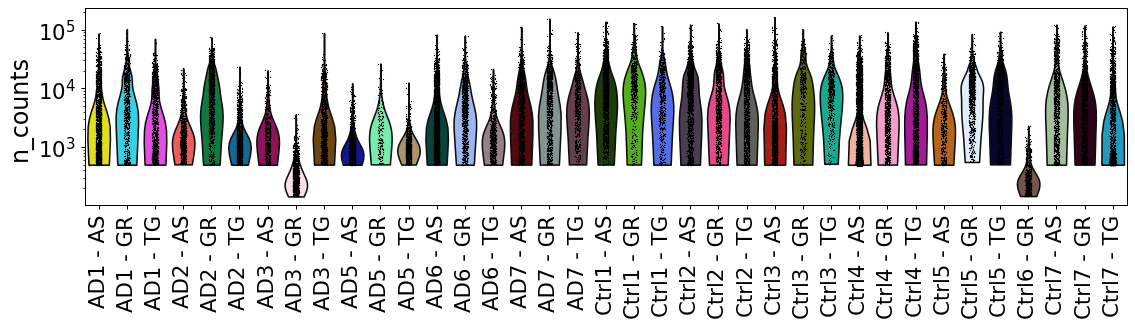

In [266]:
plt.rcParams['figure.figsize']= (12, 3)
ax = sc.pl.violin(
    adata, 
    ['n_counts'], 
    groupby='tech_sample', 
    size=1, log=True, rotation=90, save="_log_counts.png"
)

**AD3 - GR** and **Ctrl6 - GR** have low number counts. Removing Ctrl6 - GR is fine because it contains about 500 cells but AD3 - GR contains about 1.5k cells. 

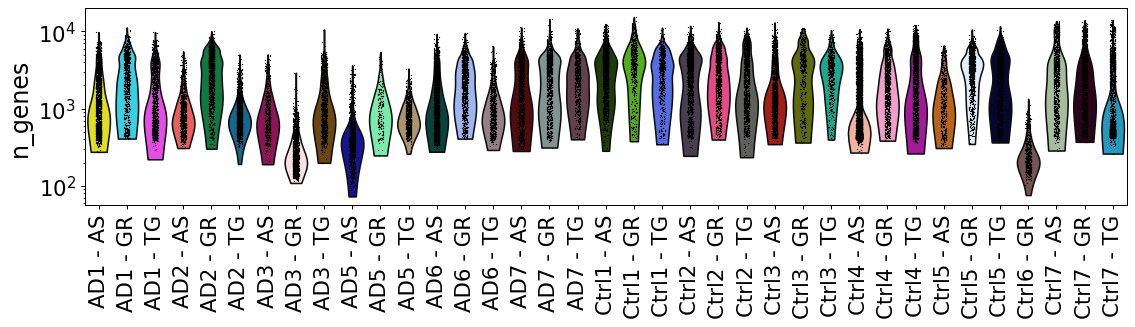

In [267]:
plt.rcParams['figure.figsize']= (12, 3)
ax = sc.pl.violin(
    adata, 
    ['n_genes'], 
    groupby='tech_sample', 
    size=1, log=True, rotation=90, save="_n_genes.png"
)

Again **AD3 - GR** and **Ctrl6 - GR** have low number genes but also **AD5 - AD**. 

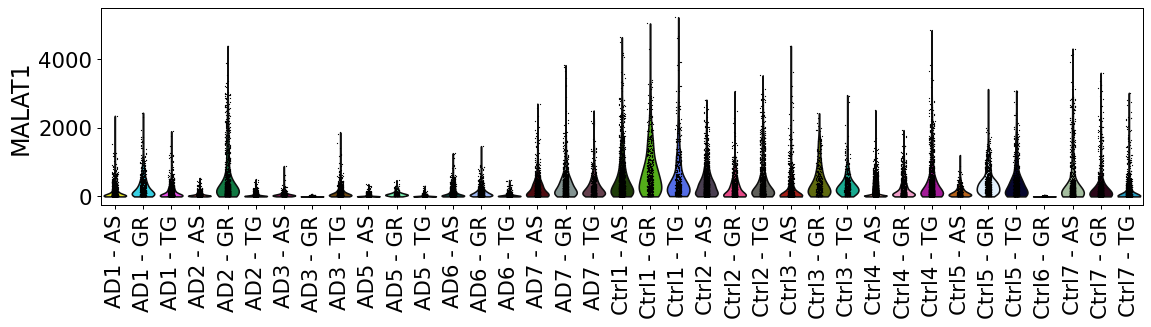

In [268]:
plt.rcParams['figure.figsize']= (12, 3)
sc.pl.violin(adata, ['MALAT1'], groupby='tech_sample', size=1, log=False, rotation=90, save="_malat1_fraction.png")

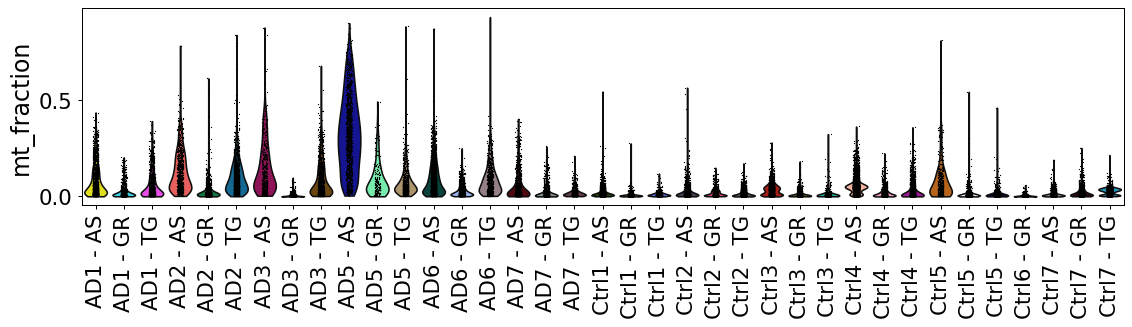

In [269]:
plt.rcParams['figure.figsize']= (12, 3)
sc.pl.violin(adata, ['mt_fraction'], groupby='tech_sample', size=1, log=False, rotation=90, save="_mt_fraction.png")

In [53]:
df = adata.obs[["n_counts", "pct_counts_mt", "pct_counts_nuclear", "condition", "area"]].copy()

In [54]:
adata.uns['area_colors'] = adata.uns['brain area latin_colors']

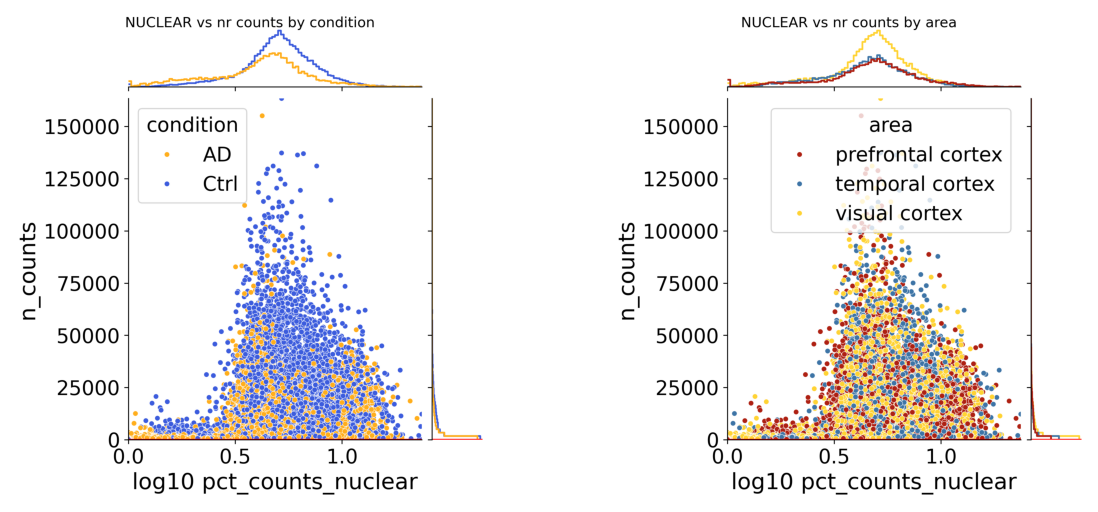

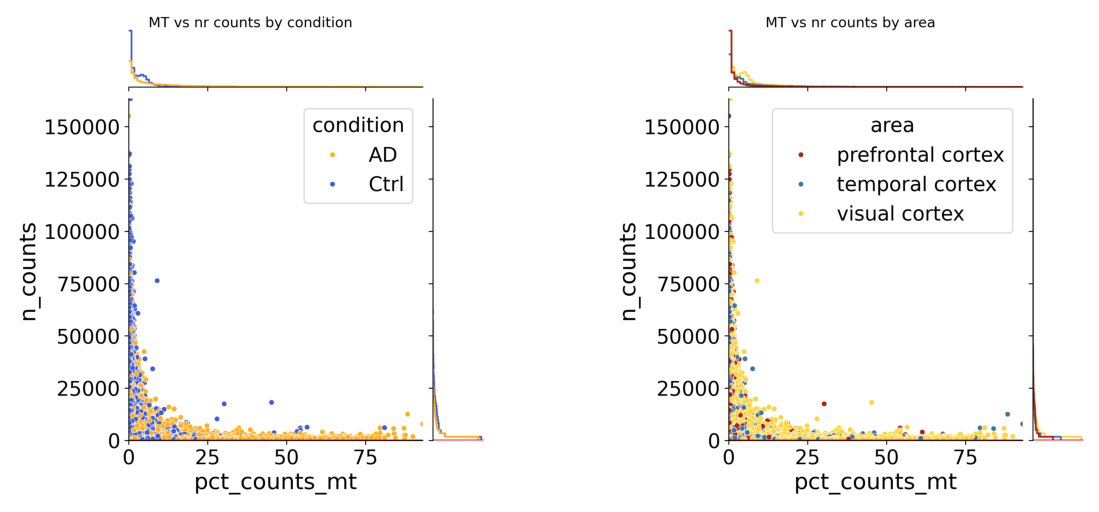

In [56]:
for name, x_name, log_x in [("NUCLEAR", "pct_counts_nuclear", 10), ("MT","pct_counts_mt", 1)]:

    condition_palette = dict(zip(adata.obs["condition"].cat.categories, adata.uns["condition_colors"]))
    area_palette = dict(zip(adata.obs["area"].cat.categories, adata.uns["area_colors"]))
    # First plot
    g1 = plot_qc_joint(
        df=df,
        x=x_name,
        y="n_counts",
        log_x=log_x,
        hue="condition",
        marginal_hue="condition",
        x_threshold=(0, np.inf),
        y_threshold=(2.5, np.inf),
        title=f"{name} vs nr counts by condition",
        s=20,
        palette=condition_palette
    )
    
    # Second plot
    g2 = plot_qc_joint(
        df=df,
        x=x_name,
        y="n_counts",
        log_x=log_x,
        hue="area",
        marginal_hue="area",
        x_threshold=(0, np.inf),
        y_threshold=(2.5, np.inf),
        title=f"{name} vs nr counts by area",
        s=20,
        palette=area_palette
    )
    
    # Save both plots
    g1.fig.savefig(f"{FIG_DIR}/{x_name}_condition.png", bbox_inches='tight')
    g2.fig.savefig(f"{FIG_DIR}/{x_name}_area.png", bbox_inches='tight')
    
    # Now combine both into one figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    img1 = plt.imread(f"{FIG_DIR}/{x_name}_condition.png")
    img2 = plt.imread(f"{FIG_DIR}/{x_name}_area.png")
    
    axs[0].imshow(img1)
    axs[0].axis("off")
    axs[1].imshow(img2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()


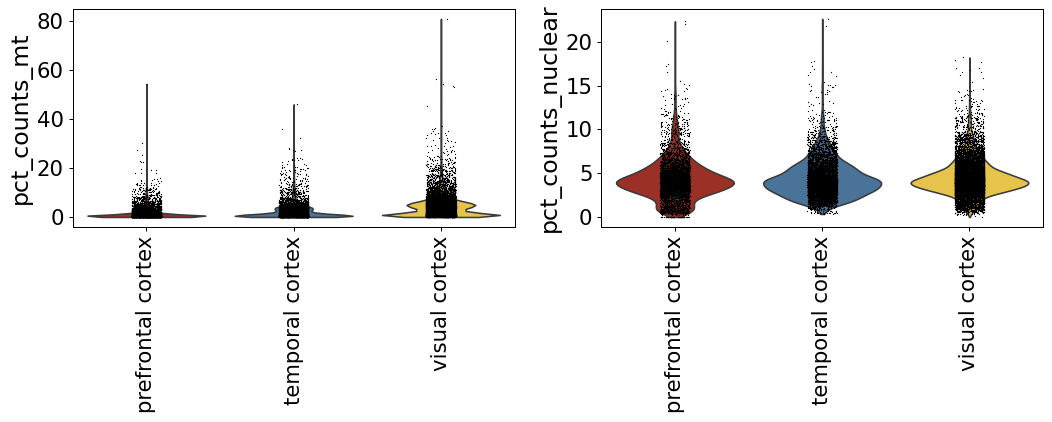

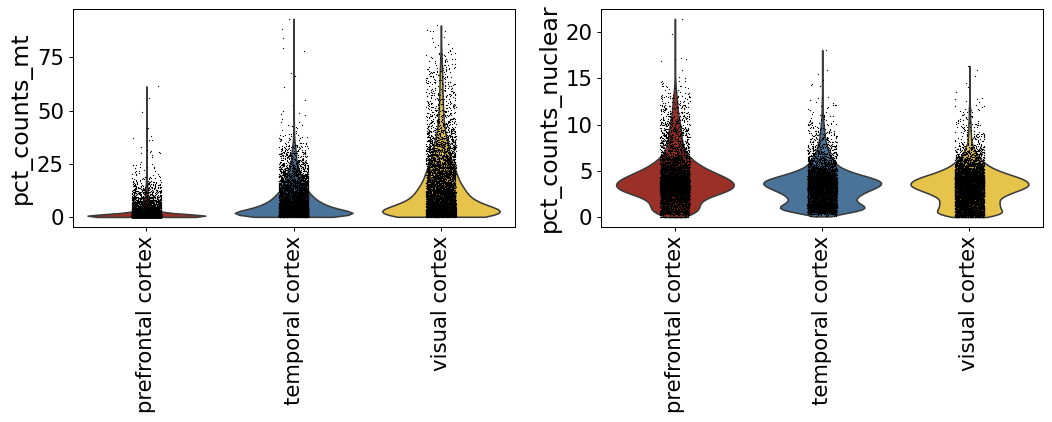

In [58]:
for cond in ['Ctrl', 'AD']:

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # you can adjust figsize here
    
    # Subset your data
    adata_ctrl = adata[adata.obs['condition'] == cond]
    
    # Plot into specific axes without saving to file
    sc.pl.violin(adata_ctrl, ['pct_counts_mt'], groupby='area',size=1,log=False,rotation=90,ax=axs[0],show=False)
    sc.pl.violin(adata_ctrl, ['pct_counts_nuclear'], groupby='area', size=1, log=False, rotation=90, ax=axs[1], show=False)
    
    plt.tight_layout()
    plt.savefig(f"mt_malat1_brain_area_{cond}_combined.png")  # Save full subplot
    plt.show()
    del adata_ctrl

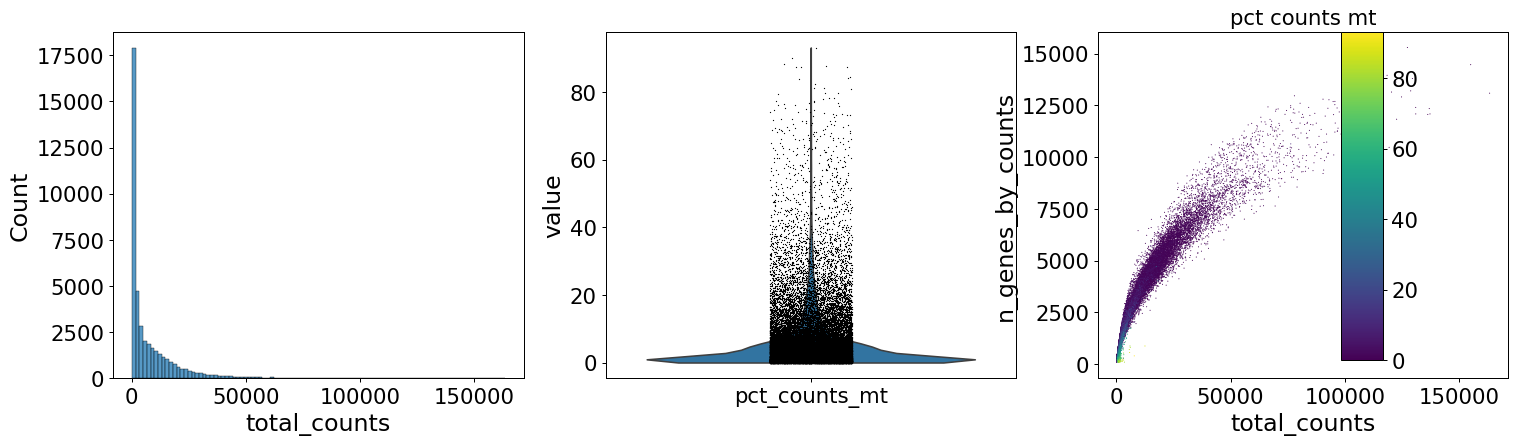

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plt.rcParams['figure.figsize']= (5, 3)
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axs[0])
sc.pl.violin(adata, "pct_counts_mt", ax=axs[1], show=False)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=axs[2], show=False, legend_loc='right margin' )

plt.savefig("sc_quality_control.png")  # Save full subplot
plt.show()

## QC by clustering

From the previous section it seems that **AD3 - GR**, **Ctrl6 - GR** and **AD5 - AD** could be low quality samples. The problem is that some might still high quality cells. Can we identify low quality cells through clustering?

In [60]:
adata.layers['log1p_norm'] = np.log1p(sc.pp.normalize_total(adata, inplace=False)['X'])

normalizing counts per cell
    finished (0:00:00)


In [61]:
adata.X = adata.layers["log1p_norm"]
adata.obs['log1p_counts'] = adata.layers["log1p_norm"].sum(1)

In [62]:
sc.tl.pca(adata,n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=30
    finished (0:00:55)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:12)
running Leiden clustering


/localscratch/francesca.drummer/ipykernel_2989237/2203707077.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished (0:00:24)
computing UMAP
    finished (0:00:25)


In [63]:
adata

AnnData object with n_obs × n_vars = 42540 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'brain area lat

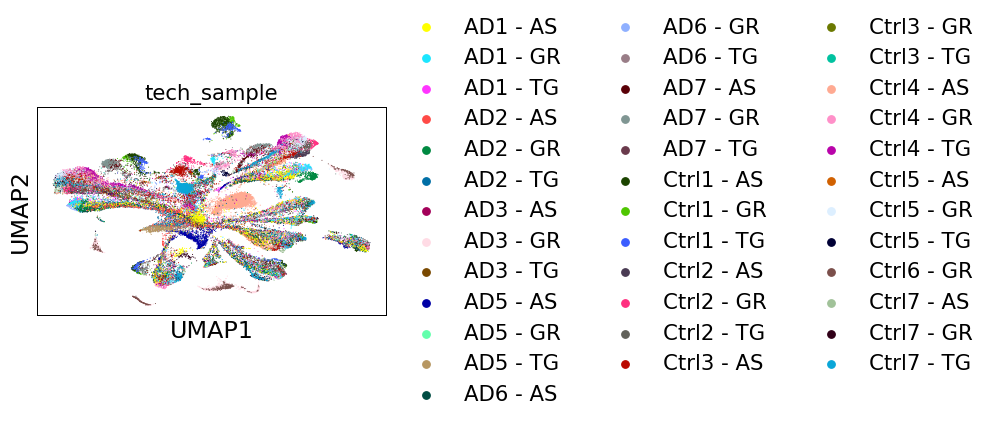

In [64]:
sc.pl.umap(adata, color='tech_sample')

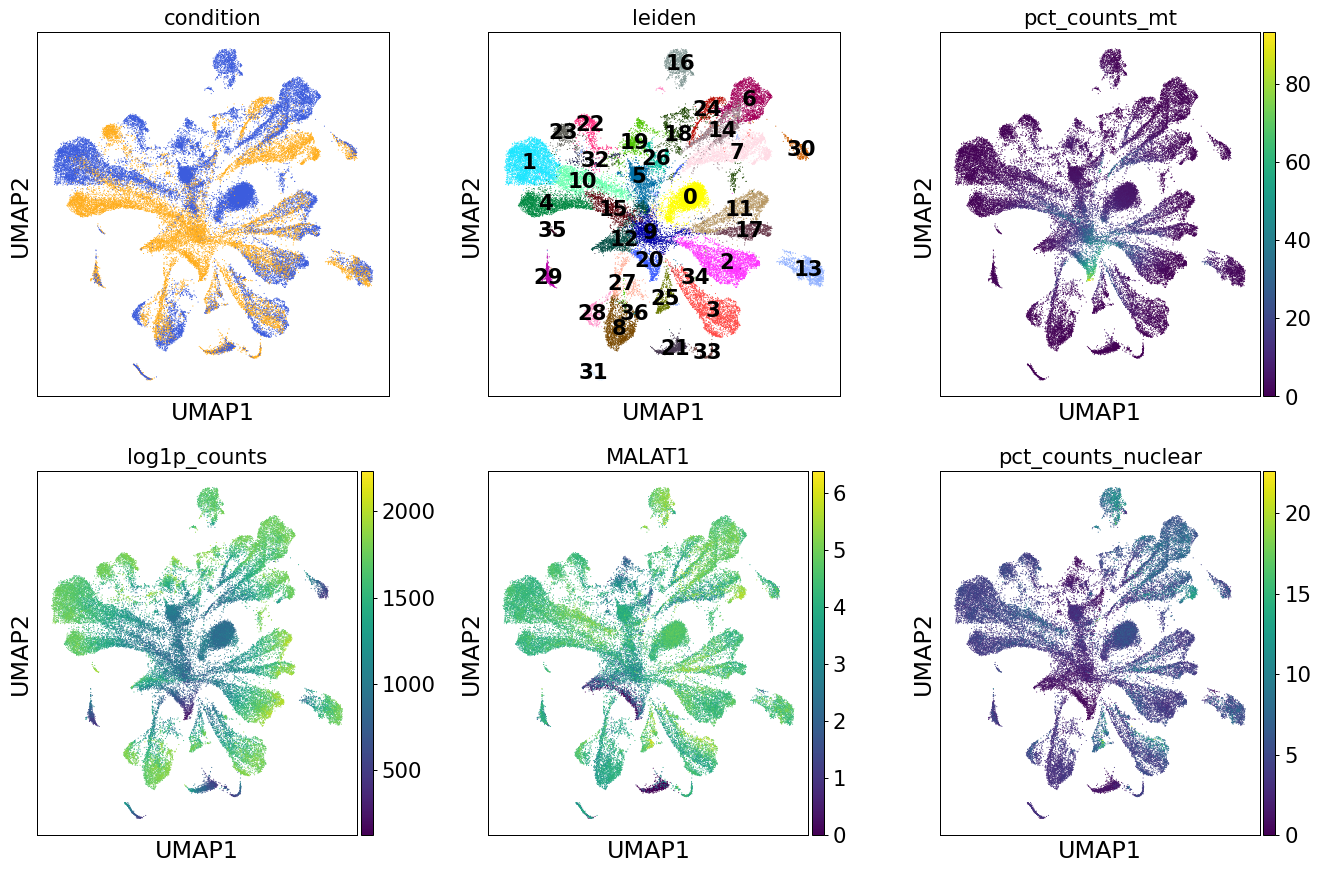

In [72]:
import matplotlib.pyplot as plt
import scanpy as sc

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt.rcParams['figure.figsize']= (8, 8)
axs = axs.flatten()

# Plot UMAPs without legends
sc.pl.umap(adata, color='condition', ax=axs[0], show=False, legend_loc=None)
sc.pl.umap(adata, color='leiden', ax=axs[1], show=False, legend_loc='on data')
sc.pl.umap(adata, color='pct_counts_mt', ax=axs[2], show=False, legend_loc=None)
sc.pl.umap(adata, color='log1p_counts', ax=axs[3], show=False, legend_loc=None)
sc.pl.umap(adata, color='MALAT1', ax=axs[4], show=False, legend_loc=None)
sc.pl.umap(adata, color='pct_counts_nuclear', ax=axs[5], show=False, legend_loc=None)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/combined_umap_subplots_no_legend.png")  # Optional
plt.show()

We observe that leiden cluster 
- **20**: high MT and low MALAT1 fraction -> remove
- **21** low MALAT1 -> remove?
- **29**, **30**, **31**, **33** have low log1p counts 

MALAT1 not consistent with MT and not highlighting everything, e.i. Ctrl 4 AD. NOt just filter on counts because you have difference in biology.

After removing them by clusters can I already see less variation?

In [73]:
# Define the Leiden clusters to remove (all other clusters will be kept)
clusters_to_remove = ['20', '21', '29', '30', '31', '33']

# Filter the AnnData object to exclude cells from the specified clusters
adata_filtered = adata[~adata.obs['leiden'].isin(clusters_to_remove)].copy()

In [74]:
tech_sample_counts_before = adata.obs['tech_sample'].value_counts()
tech_sample_counts_after = adata_filtered.obs['tech_sample'].value_counts()
tech_sample_counts_after = tech_sample_counts_after.reindex(tech_sample_counts_before.index).fillna(0).astype(int)
tech_sample_removed = tech_sample_counts_before - tech_sample_counts_after
tech_sample_removed = tech_sample_removed[tech_sample_removed > 0]
print(f'Total nr. of cells removed: {len(adata.obs_names) - len(adata_filtered.obs_names)}')
print(f'Cells removed per tech_sample (where more than 0 cells were removed):\n{tech_sample_removed}')

Total nr. of cells removed: 2757
Cells removed per tech_sample (where more than 0 cells were removed):
tech_sample
Ctrl4 - AS       3
AD6 - AS         1
Ctrl2 - AS       5
AD3 - GR      1430
Ctrl3 - AS       1
AD2 - TG         7
AD1 - TG         1
Ctrl2 - TG       1
AD5 - AS       735
Ctrl4 - GR       1
AD3 - TG         2
Ctrl5 - GR       8
Ctrl7 - AS       4
AD7 - GR         3
AD2 - AS         1
AD7 - AS         1
Ctrl5 - TG       1
AD6 - TG         2
AD5 - TG        24
Ctrl3 - TG       2
Ctrl6 - GR     510
AD3 - AS         7
Ctrl5 - AS       2
AD5 - GR         5
Name: count, dtype: int64


Most cells were removed from the tech samples that we previously observed as low quality samples (**AD3 - GR**, **AD5 - AS**, **Ctrl6 - GR**).

Now we again observe the quality control measures like before to check whether they are now performing better. 

In [75]:
adata_filtered

AnnData object with n_obs × n_vars = 39783 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'brain area lat

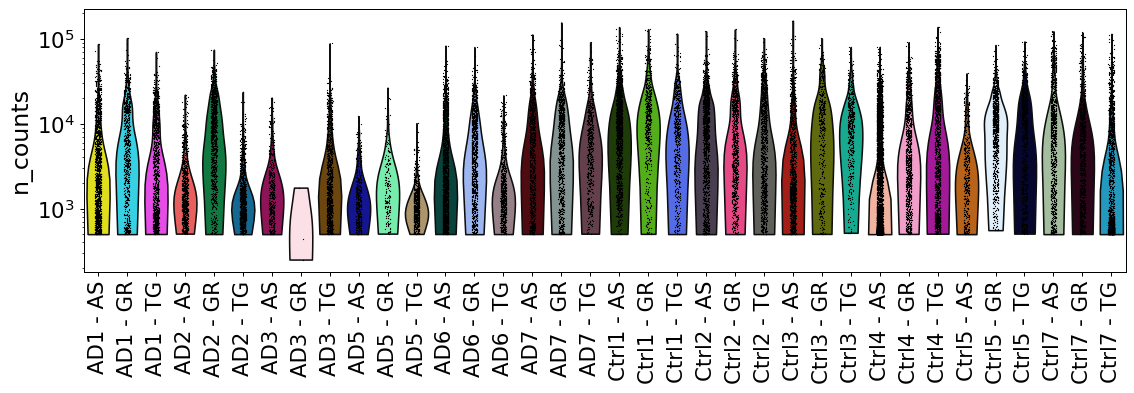

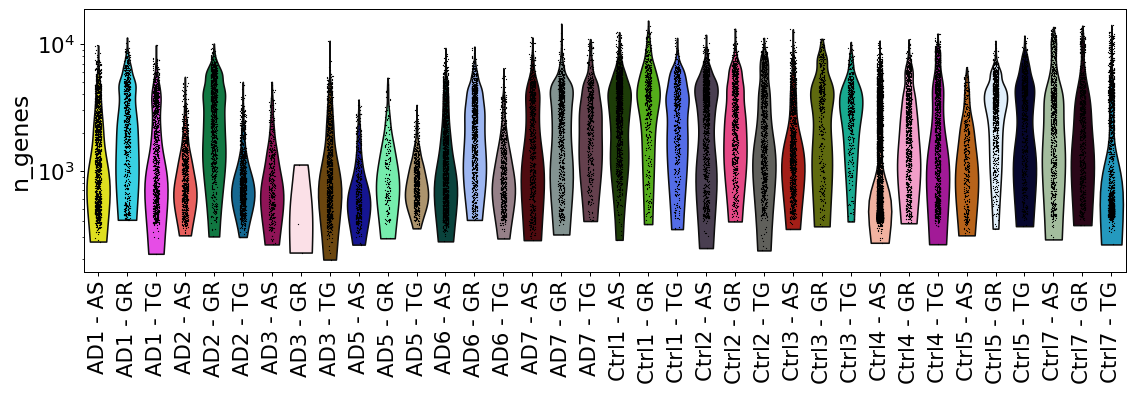

In [76]:
plt.rcParams['figure.figsize']= (12, 4)
sc.pl.violin(adata_filtered, ['n_counts'], groupby='tech_sample', size=1, log=True, rotation=90)
plt.rcParams['figure.figsize']= (12, 4)
sc.pl.violin(adata_filtered, ['n_genes'], groupby='tech_sample', size=1, log=True, rotation=90)

Tech sample **Ctrl6 - GR** was completly removed and only one cell of **AD3 - GR**left -> remove.

**AD5 - AS** has a high mt fraction but normal MALAT1 distirbution. 

**AD5 -TG** has a skewed MALAT1 distribution but mt fraction is fine.

In [77]:
# Filter the AnnData object to exclude cells from the specified clusters
adata_filtered = adata_filtered[~adata_filtered.obs['tech_sample'].isin(['AD3 - GR'])].copy()

In [81]:
df = adata_filtered.obs[["n_counts", "pct_counts_mt", "pct_counts_nuclear", "condition", "area"]].copy()

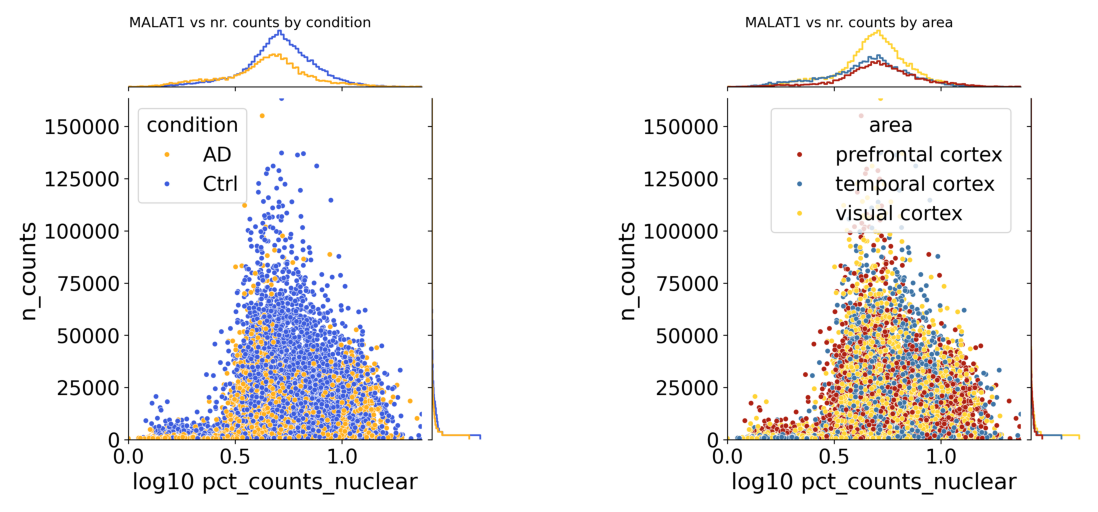

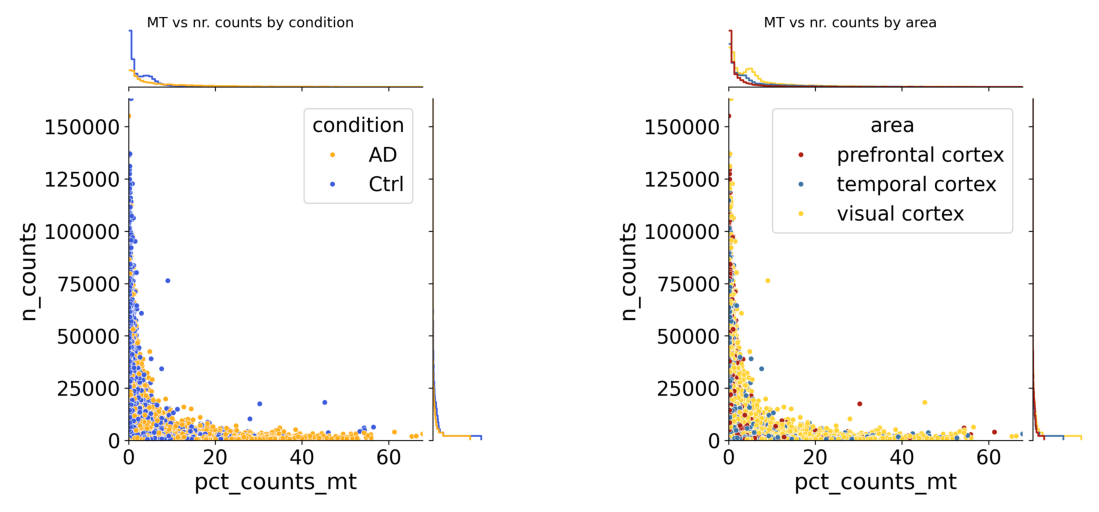

In [83]:
for name, x_name, log_x in [("MALAT1", "pct_counts_nuclear", 10), ("MT","pct_counts_mt", 1)]:

    condition_palette = dict(zip(adata_filtered.obs["condition"].cat.categories, adata_filtered.uns["condition_colors"]))
    area_palette = dict(zip(adata_filtered.obs["area"].cat.categories, adata_filtered.uns["area_colors"]))
    # First plot
    g1 = plot_qc_joint(
        df=df,
        x=x_name,
        y="n_counts",
        log_x=log_x,
        hue="condition",
        marginal_hue="condition",
        x_threshold=(0, np.inf),
        title=f"{name} vs nr. counts by condition",
        s=20,
        palette=condition_palette
    )
    
    # Second plot
    g2 = plot_qc_joint(
        df=df,
        x=x_name,
        y="n_counts",
        log_x=log_x,
        hue="area",
        marginal_hue="area",
        x_threshold=(0, np.inf),
        title=f"{name} vs nr. counts by area",
        s=20,
        palette=area_palette
    )
    
    # Save both plots
    g1.fig.savefig(f"{FIG_DIR}/{x_name}_condition_filtered1.png", bbox_inches='tight')
    g2.fig.savefig(f"{FIG_DIR}/{x_name}_area_filtered1.png", bbox_inches='tight')
    
    # Now combine both into one figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    img1 = plt.imread(f"{FIG_DIR}/{x_name}_condition_filtered1.png")
    img2 = plt.imread(f"{FIG_DIR}/{x_name}_area_filtered1.png")
    
    axs[0].imshow(img1)
    axs[0].axis("off")
    axs[1].imshow(img2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()


In [85]:
adata_filtered.write(Path(DATA_DIR / f"{VERSION}_adata_filtered_counts_matrix.h5ad"))

# Condition + Area specific thresholds

Besides technical variation, the samples included in the data seem to show biologically related variation across condition and area. 

In [34]:
adata_filtered = sc.read_h5ad(Path(DATA_DIR / f"{VERSION}_adata_filtered_counts_matrix.h5ad"))
adata_filtered

AnnData object with n_obs × n_vars = 39780 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'Braak stage', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'area_colors', 

In [14]:
print(f"Nuclear pct: {adata_filtered.obs['pct_counts_nuclear'].max()}, MT pct: {adata_filtered.obs['pct_counts_mt'].max()}")

Nuclear pct: 22.623512268066406, MT pct: 67.8525619506836


In [43]:
adata_filtered.obs['braak_stage'] = adata_filtered.obs['Braak stage'].astype('category')
del adata_filtered.obs['Braak stage']

/localscratch/francesca.drummer/ipykernel_6117/401652287.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_data = adata.obs.groupby(sample_col).agg({


Plot saved to: /ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/quality_control/scattered_boxplot_mito_braak.png

Sample counts by group:
braak_stage
0     9
1     6
2     3
5     6
6    11
Name: count, dtype: int64

Summary statistics by group:
Braak 0: n=9, mean=-4.948, std=0.302
Braak 1: n=6, mean=-4.717, std=0.586
Braak 2: n=3, mean=-4.507, std=0.956
Braak 5: n=6, mean=-3.956, std=0.759
Braak 6: n=11, mean=-3.165, std=0.865


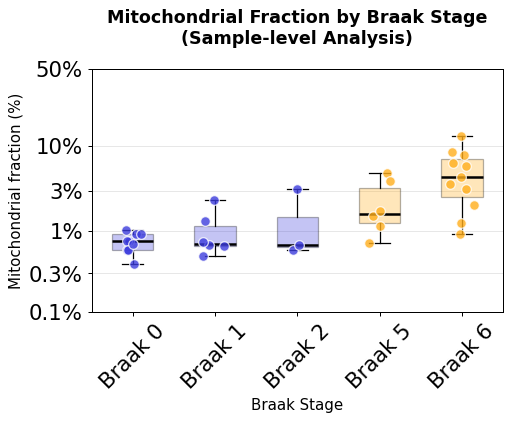

In [37]:
fig, ax, sample_data = plot_scattered_boxplot_mito(
    adata_filtered, 
    count_col = 'total_counts_mt',
    sample_col='sample',
    group_col='braak_stage',
    figsize=(6, 5),
    save_path=Path(FIG_DIR, 'scattered_boxplot_mito_braak.png')
)
plt.show()

/localscratch/francesca.drummer/ipykernel_6117/401652287.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_data = adata.obs.groupby(sample_col).agg({


Plot saved to: /ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/quality_control/scattered_boxplot_nuclear_braak.png

Sample counts by group:
braak_stage
0     9
1     6
2     3
5     6
6    11
Name: count, dtype: int64

Summary statistics by group:
Braak 0: n=9, mean=-2.936, std=0.247
Braak 1: n=6, mean=-3.079, std=0.067
Braak 2: n=3, mean=-2.987, std=0.123
Braak 5: n=6, mean=-3.165, std=0.198
Braak 6: n=11, mean=-3.148, std=0.261


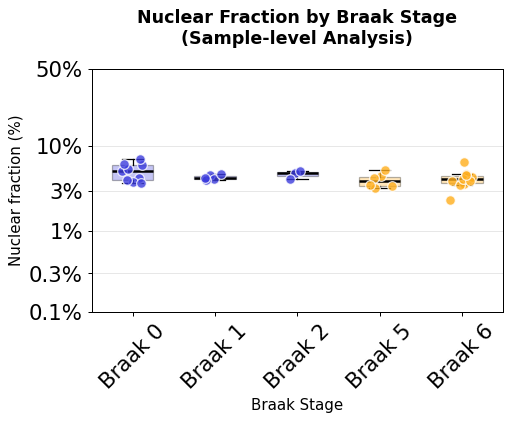

In [36]:
fig, ax, sample_data = plot_scattered_boxplot_mito(
    adata_filtered, 
    count_col = 'total_counts_nuclear',
    sample_col='sample',
    group_col='braak_stage',
    figsize=(6, 5),
    save_path=Path(FIG_DIR, 'scattered_boxplot_nuclear_braak.png')
)
plt.show()

/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/notebooks_May25/../utils/qc.py:433: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'total_counts_mt': 'sum',


Plot saved to: /ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/scattered_boxplot_mito_braak_per_area.png

Sample counts by group and area:
area         prefrontal cortex  temporal cortex  visual cortex  All
braak_stage                                                        
0                            3                3              3    9
1                            2                2              2    6
2                            1                1              1    3
5                            2                2              2    6
6                            3                4              4   11
All                         11               12             12   35


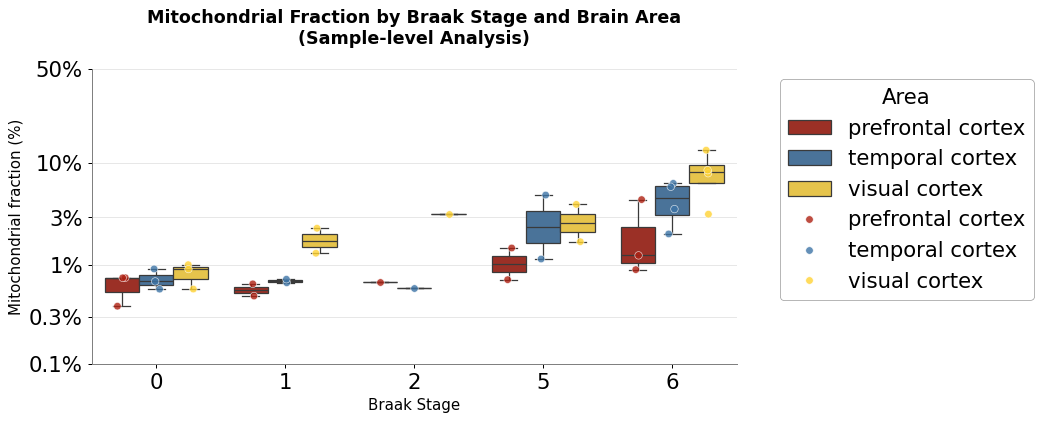

In [46]:
fig, ax, data = simple_logit_boxplot(adata_filtered, sample_col='sample', colors=AREA_COLOR, save_path = Path(FIG_DIR, 'scattered_boxplot_mito_braak_per_area.png'))
plt.show()

/ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/notebooks_May25/../utils/qc.py:440: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_data['logit_mito'] = logit((sample_data['total_counts_mt'] + 1) /


Plot saved to: /ictstr01/home/icb/francesca.drummer/jaekel/ad_jaekel/figures/scattered_boxplot_nuclear_braak_per_area.png

Sample counts by group and area:
area         prefrontal cortex  temporal cortex  visual cortex  All
braak_stage                                                        
0                            3                3              3    9
1                            2                2              2    6
2                            1                1              1    3
5                            2                2              2    6
6                            3                4              4   11
All                         11               12             12   35


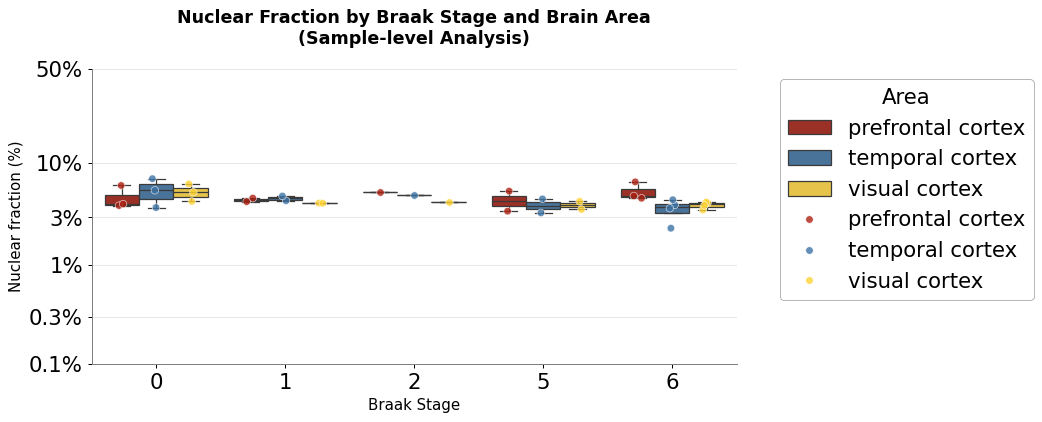

In [49]:
fig, ax, data = simple_logit_boxplot(adata_filtered, count_col = 'total_counts_nuclear', sample_col='sample', colors=AREA_COLOR, save_path = Path(FIG_DIR, 'scattered_boxplot_nuclear_braak_per_area.png'))
plt.show()

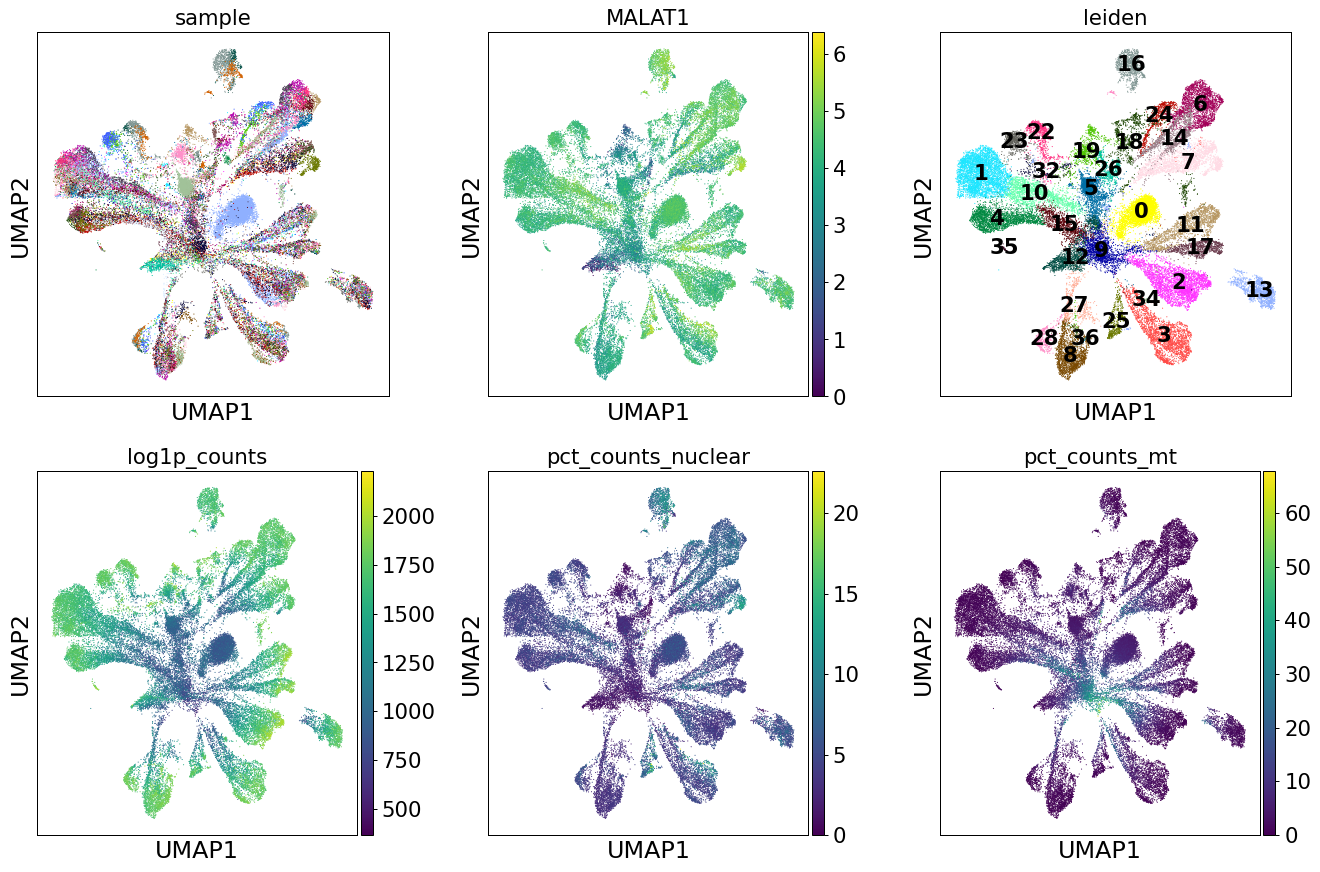

In [94]:
import matplotlib.pyplot as plt
import scanpy as sc

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt.rcParams['figure.figsize']= (6, 6)
axs = axs.flatten()

# Plot UMAPs without legends
sc.pl.umap(adata_filtered, color='sample', ax=axs[0], show=False, legend_loc=None)
sc.pl.umap(adata_filtered, color='MALAT1', ax=axs[1], show=False, legend_loc=None)
sc.pl.umap(adata_filtered, color='leiden', ax=axs[2], show=False, legend_loc='on data')
sc.pl.umap(adata_filtered, color='log1p_counts', ax=axs[3], show=False, legend_loc=None)
sc.pl.umap(adata_filtered, color='pct_counts_nuclear', ax=axs[4], show=False, legend_loc=None)
sc.pl.umap(adata_filtered, color='pct_counts_mt', ax=axs[5], show=False, legend_loc=None)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/filtered_combined_umap_subplots_no_legend.png")  # Optional
plt.show()

From the UMAP above we also observe that cells in cluster **0** and **5** have low log1p counts and mainly come from one sample. 
This means the cells from the samples don't seem to integrate well with the rest suggesting to be outliers.
For now we will keep them in but potentially remove the clusters if there are a lot of e.i. doublets.

In [28]:
# clusters_to_remove = ['0', '5']
# adata_filtered = adata_filtered[~adata_filtered.obs['leiden'].isin(clusters_to_remove)].copy()

In [95]:
area_abbrev = {
    'prefrontal cortex': 'PFC',
    'temporal cortex': 'TC',
    'visual cortex': 'VC'
}

adata_filtered.obs['area_abbrev'] = adata_filtered.obs['area'].map(area_abbrev)
adata_filtered.obs['condition_area'] = adata_filtered.obs['condition'].astype(str) + '_' + adata_filtered.obs['area_abbrev'].astype(str)
np.unique(adata_filtered.obs['condition_area'])

array(['AD_PFC', 'AD_TC', 'AD_VC', 'Ctrl_PFC', 'Ctrl_TC', 'Ctrl_VC'],
      dtype=object)

In [119]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

def add_outlier_obs(adata):
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    print(adata.obs.outlier.value_counts())
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3)
    print(adata.obs.mt_outlier.value_counts())

In [122]:
# add_outlier_obs(adata_filtered)

In [123]:
# for cond_area in np.unique(adata_filtered.obs['condition_area']):
#     sub_adata = adata_filtered[adata_filtered.obs['condition_area'] == cond_area]
#     add_outlier_obs(sub_adata)

In [124]:
n_genes_threshold = {
    'AD_PFC': (400, 9000), 
    'AD_TC': (350, 7000),
    'AD_VC': (350, 8000),
    'Ctrl_PFC': (410, 10000),
    'Ctrl_TC': (410, 9500),
    'Ctrl_VC': (400, 10000)
}
n_counts_threshold = {
    'AD_PFC': (500, 50000), 
    'AD_TC': (500, 30000),
    'AD_VC': (500, 40000),
    'Ctrl_PFC': (500, 60000),
    'Ctrl_TC': (500, 60000),
    'Ctrl_VC': (500, 60000)
}
mt_threshold = {
    'AD_PFC': 10, 
    'AD_TC': 20,
    'AD_VC': 25,
    'Ctrl_PFC': 10,
    'Ctrl_TC': 10,
    'Ctrl_VC': 17
}
malat1_threshold = {
    'AD_PFC': 1, 
    'AD_TC': 0.8,
    'AD_VC': 0.8,
    'Ctrl_PFC': 1,
    'Ctrl_TC': 0.8,
    'Ctrl_VC': 0.8
}

In [125]:
adata_filtered

AnnData object with n_obs × n_vars = 39780 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden', 'braak_stage', 'area_abbrev', 'condition_area', 'outlier', 'mt_outlier'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'to

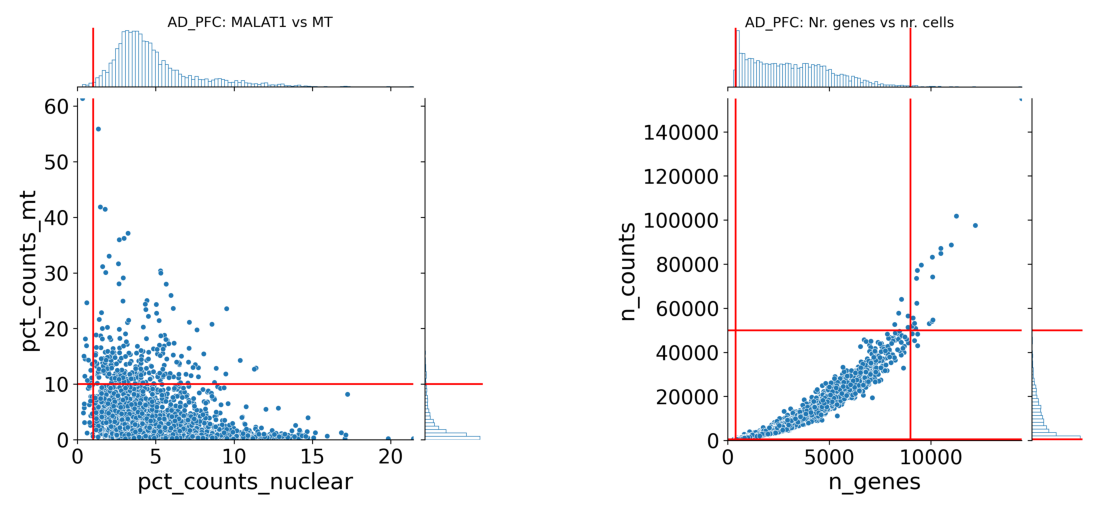

<Figure size 2250x1800 with 0 Axes>

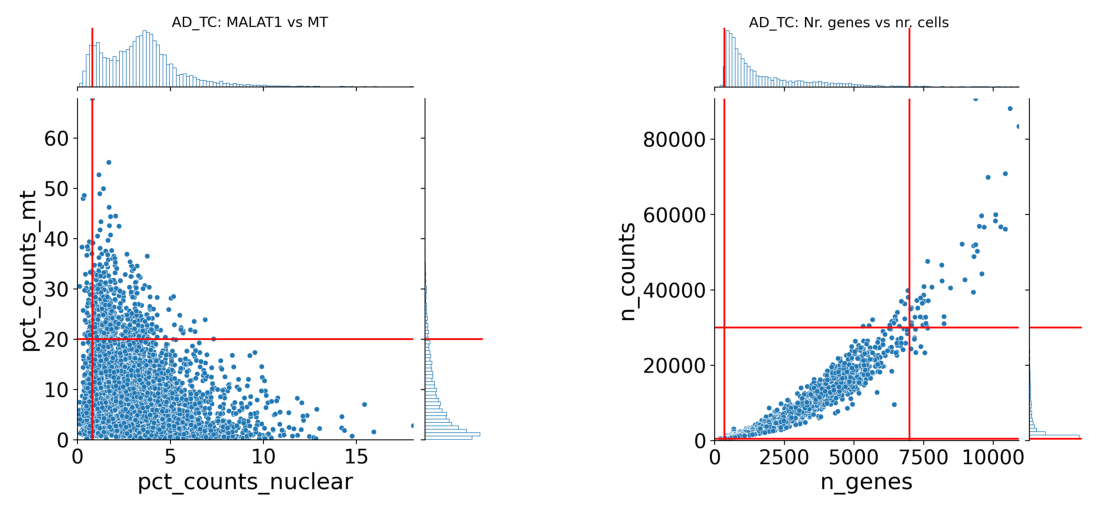

<Figure size 1260x1350 with 0 Axes>

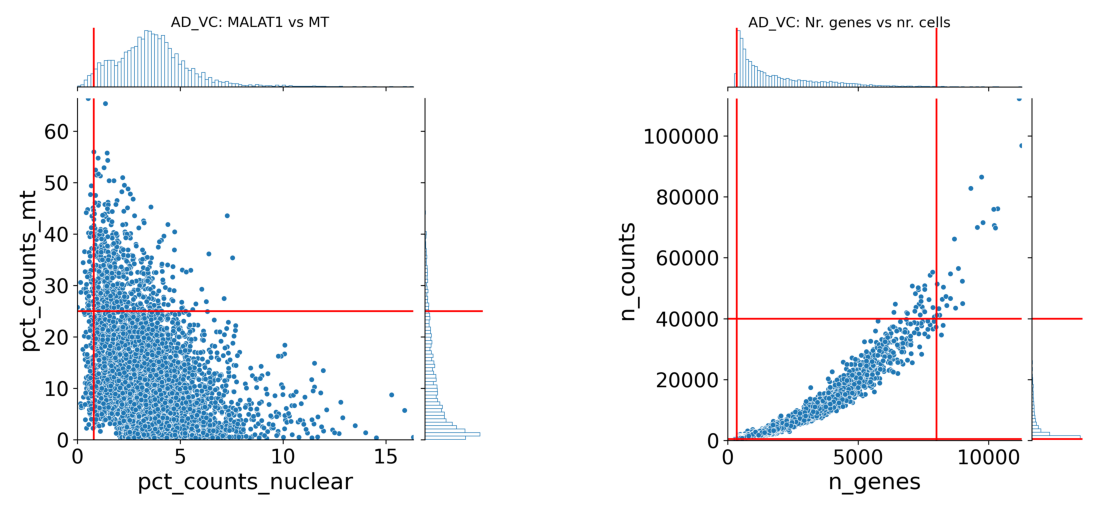

<Figure size 1260x1350 with 0 Axes>

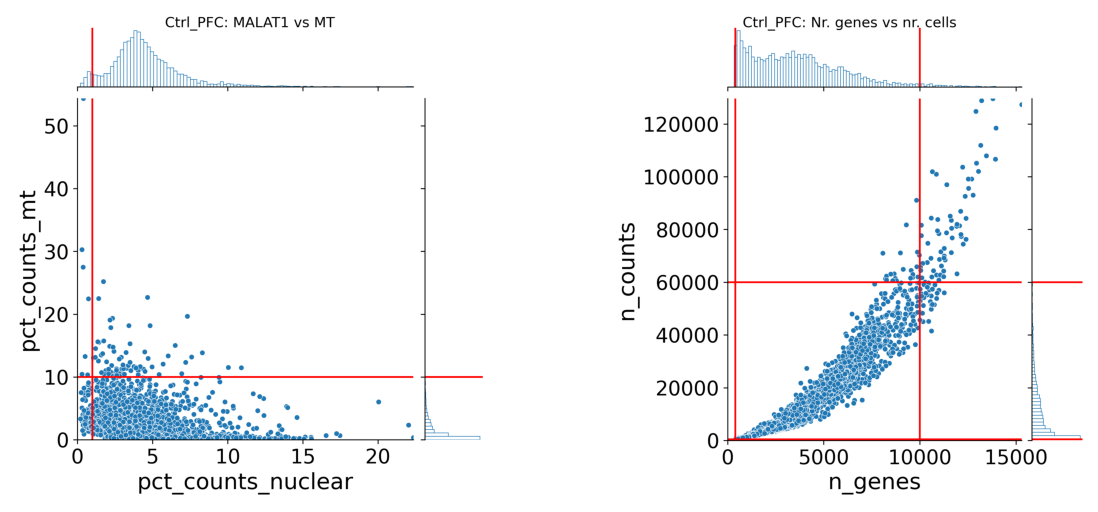

<Figure size 1260x1350 with 0 Axes>

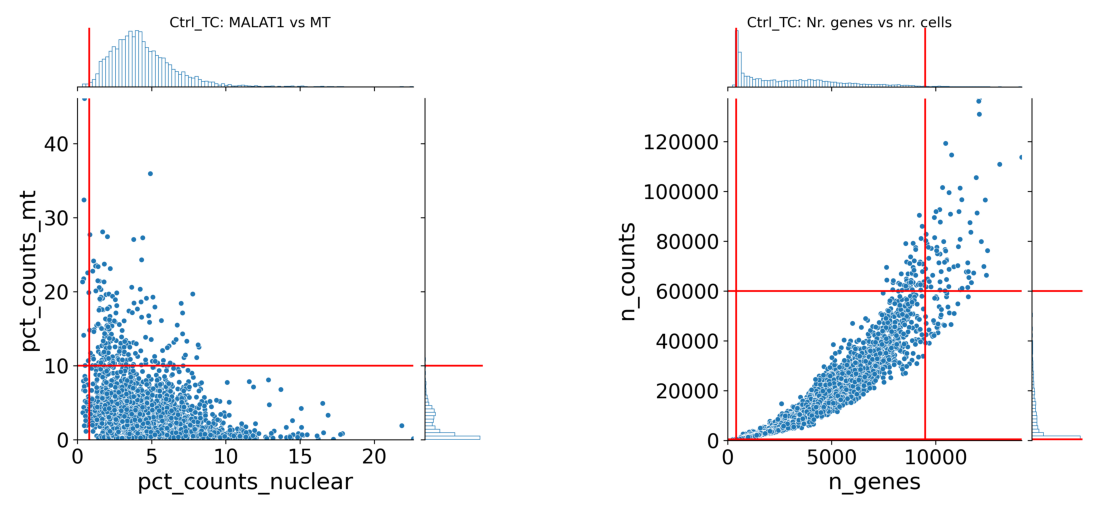

<Figure size 1260x1350 with 0 Axes>

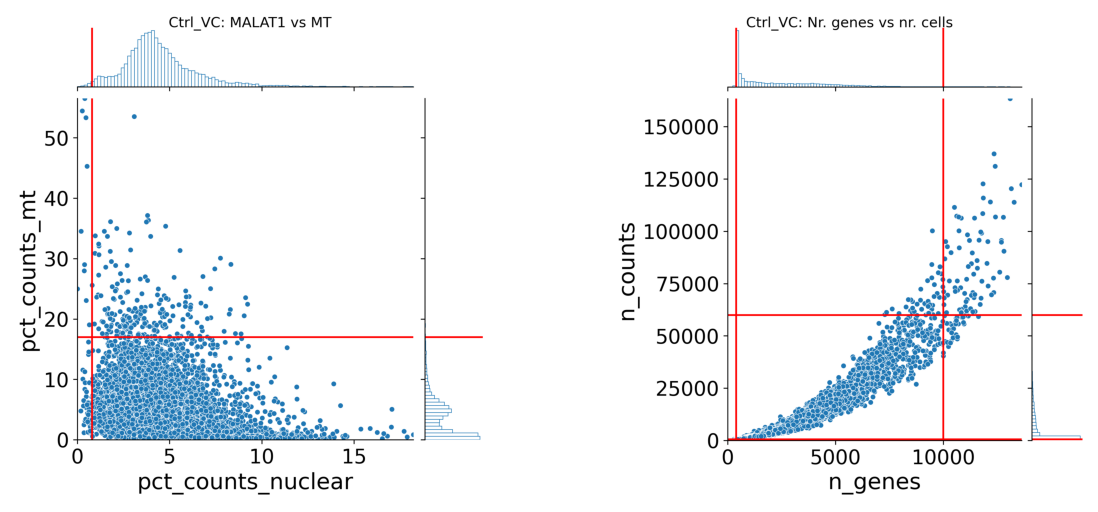

<Figure size 1260x1350 with 0 Axes>

In [126]:
for i, obs_name in enumerate(np.unique(adata_filtered.obs['condition_area'])):
    sub_adata = adata_filtered[adata_filtered.obs['condition_area'] == obs_name]
    df = sub_adata.obs[["log_counts", "pct_counts_mt", "pct_counts_nuclear", "n_genes", "n_counts"]].copy()
    g1 = plot_qc_joint(
        df=df,
        x="pct_counts_nuclear",
        y="pct_counts_mt",
        log_x=1,
        x_threshold=(0, malat1_threshold[obs_name]),
        y_threshold = (mt_threshold[obs_name], np.inf),
        title=f"{obs_name}: MALAT1 vs MT",
        s=20,
        show = False
    )
    g2 = plot_qc_joint(
        df=df,
        x="n_genes",
        y="n_counts",
        log_x=1,
        log_y=1,
        x_threshold = (n_genes_threshold[obs_name][0], n_genes_threshold[obs_name][1]),
        y_threshold = (n_counts_threshold[obs_name][0], n_counts_threshold[obs_name][1]),
        title=f"{obs_name}: Nr. genes vs nr. cells",
        s=20,
        show = False
    )
    
    # Save both plots
    g1.fig.savefig(f"{FIG_DIR}/{obs_name}_MALAT1_MT_filtered.png", bbox_inches='tight')
    g2.fig.savefig(f"{FIG_DIR}/{obs_name}_genes_counts_filtered1.png", bbox_inches='tight')
    
    # Now combine both into one figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    img1 = plt.imread(f"{FIG_DIR}/{obs_name}_MALAT1_MT_filtered.png")
    img2 = plt.imread(f"{FIG_DIR}/{obs_name}_genes_counts_filtered1.png")
    
    axs[0].imshow(img1)
    axs[0].axis("off")
    axs[1].imshow(img2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{FIG_DIR}/joint_qc_{obs_name}_malat1_mt.png")
    plt.rcParams['figure.figsize']= (14, 15)
    

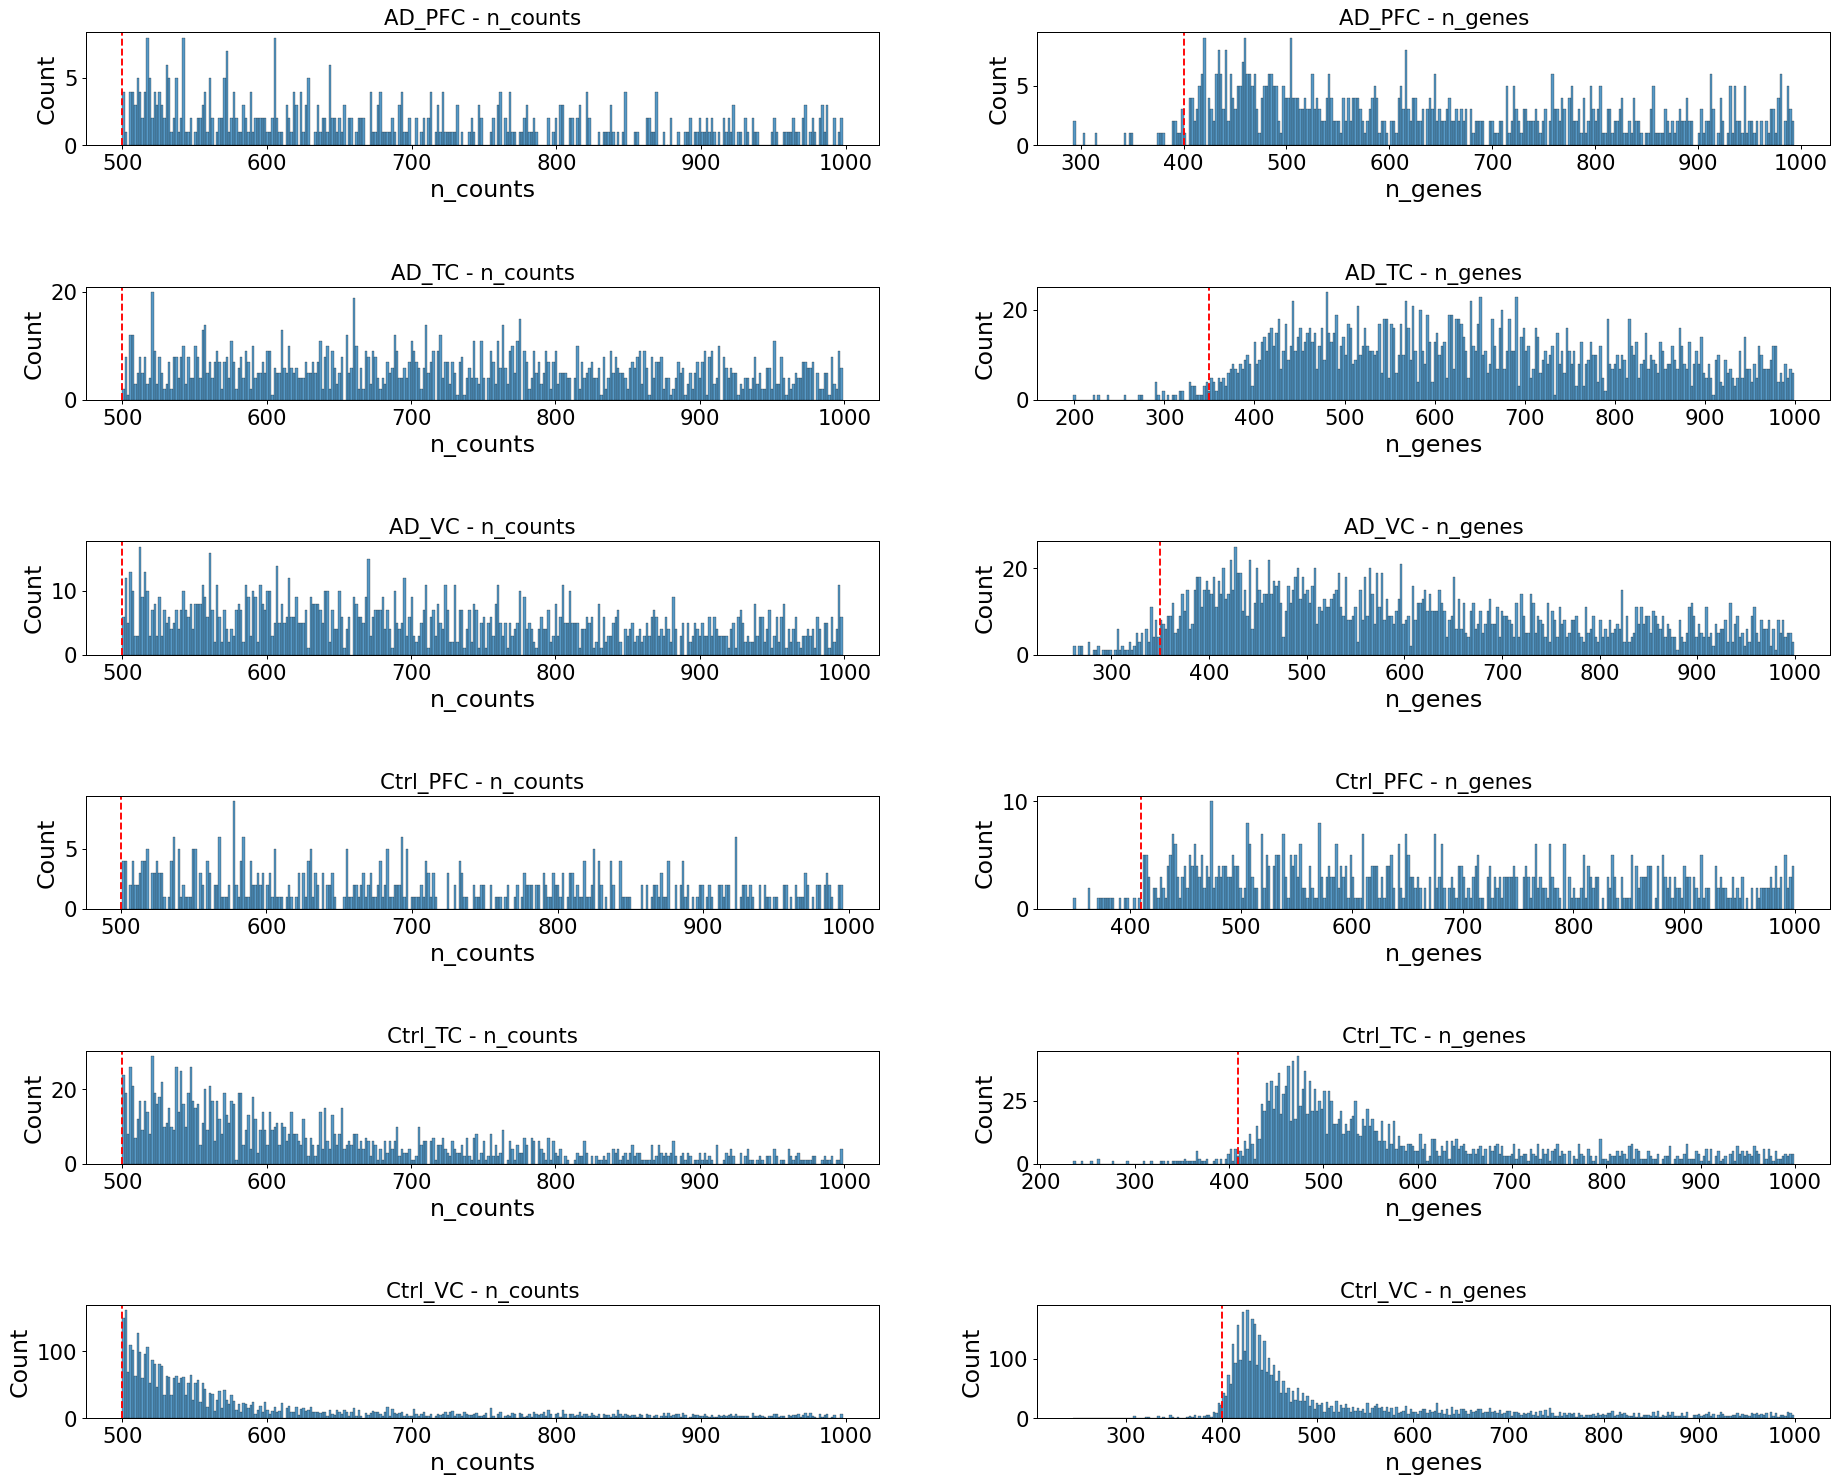

In [127]:
groups_final = np.unique(adata_filtered.obs['condition_area'])
plt.rcParams['figure.figsize']= (25, 20)
fig, axs = plt.subplots(len(groups_final), 2)
plt.subplots_adjust(hspace=1.25)

# Define your thresholds
min_counts, max_counts = 200, 800
min_genes, max_genes = 300, 900

for i, group in enumerate(groups_final):
    # Plot n_counts
    sns.histplot(adata_filtered.obs.n_counts[
        (adata_filtered.obs.condition_area == group) &
        (adata_filtered.obs.n_counts < 1000)
    ], bins=300, ax=axs[i, 0])
    axs[i, 0].axvline(n_counts_threshold[group][0], color='red', linestyle='--', label='min threshold')
    axs[i, 0].set_title(f'{group} - n_counts')

    # Plot n_genes
    sns.histplot(adata_filtered.obs.n_genes[
        (adata_filtered.obs.condition_area == group) &
        (adata_filtered.obs.n_genes < 1000)
    ], bins=300, ax=axs[i, 1])
    axs[i, 1].axvline(n_genes_threshold[group][0], color='red', linestyle='--', label='min threshold')
    axs[i, 1].set_title(f'{group} - n_genes')

plt.savefig(f"{FIG_DIR}/n_counts_and_n_genes.png")


AD_PFC


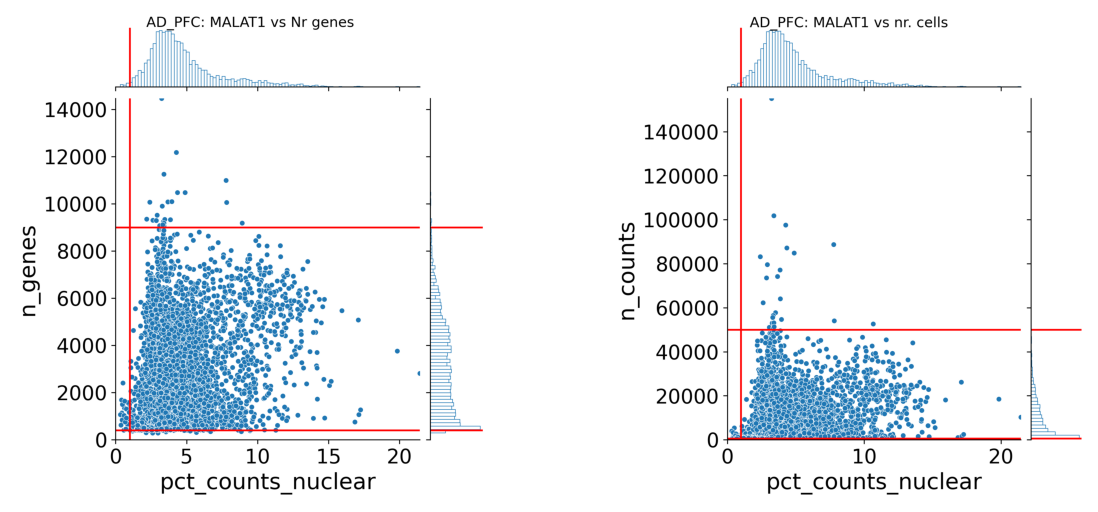

AD_TC


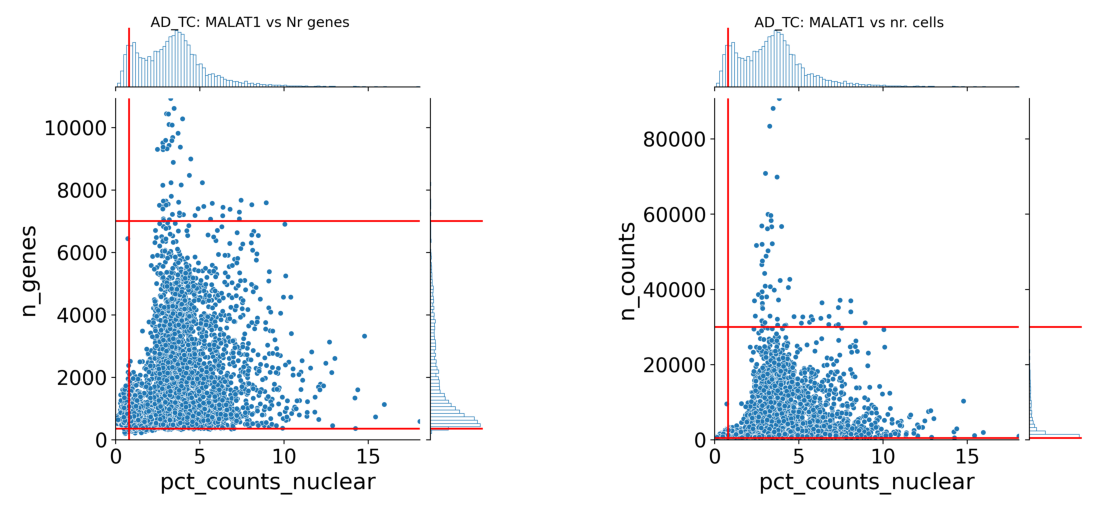

AD_VC


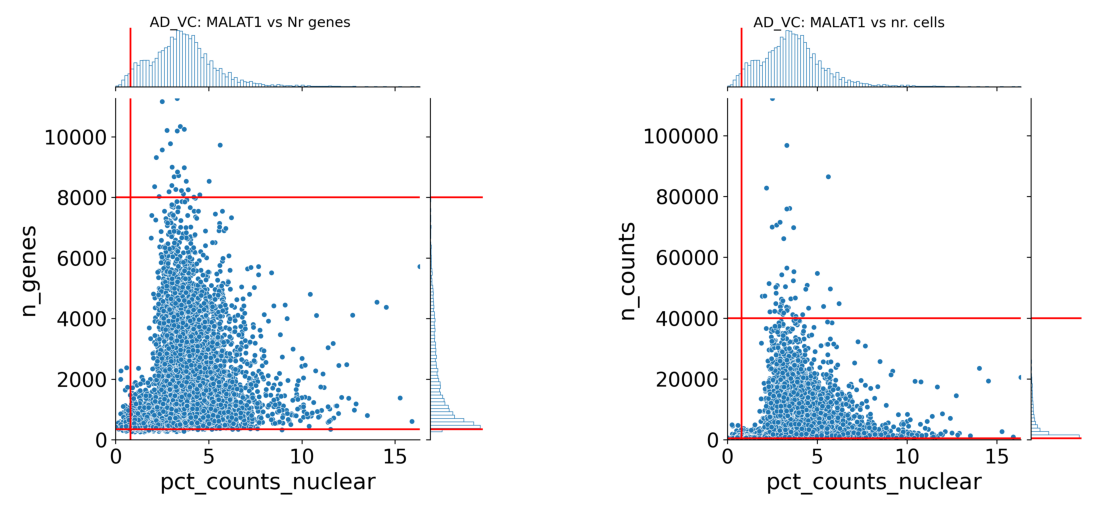

Ctrl_PFC


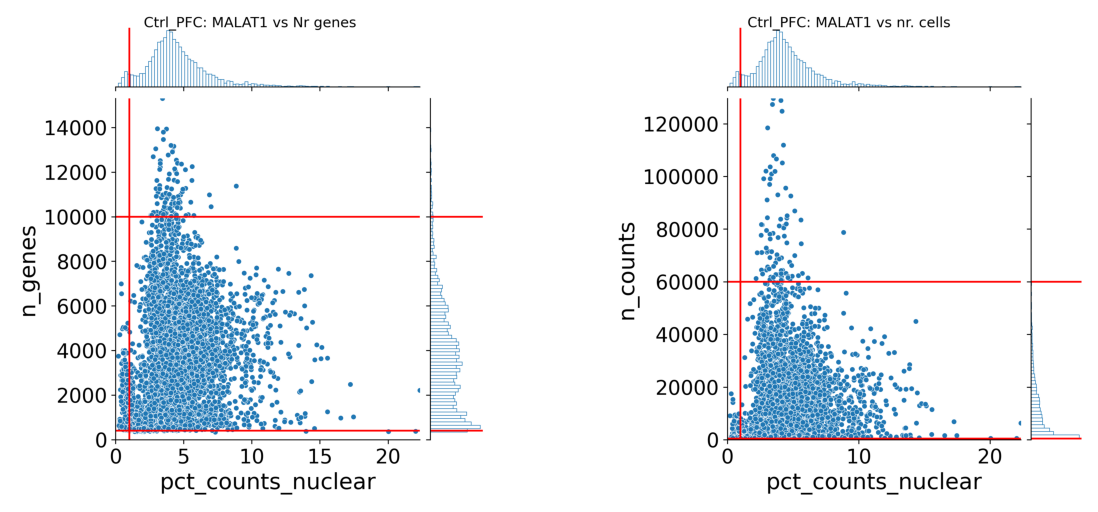

Ctrl_TC


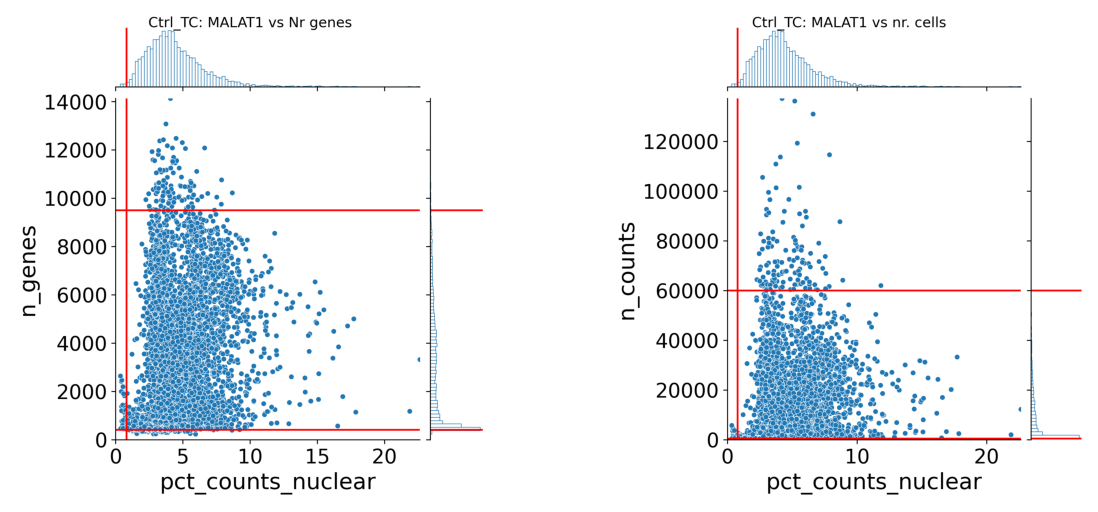

Ctrl_VC


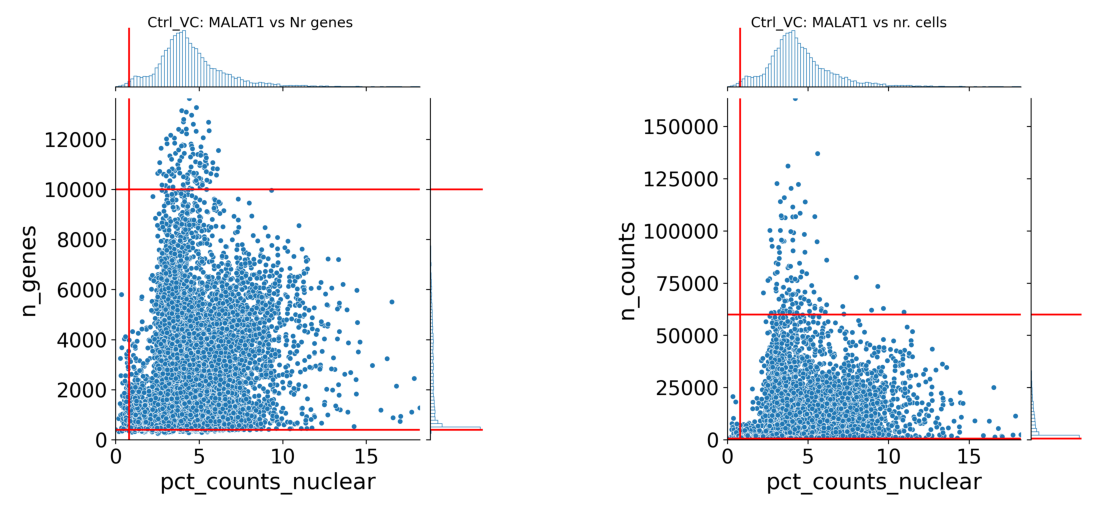

In [129]:
for i, obs_name in enumerate(np.unique(adata_filtered.obs['condition_area'])):
    print(obs_name)
    sub_adata = adata_filtered[adata_filtered.obs['condition_area'] == obs_name]
    df = sub_adata.obs[["log_counts", "pct_counts_mt", "pct_counts_nuclear", "n_genes", "n_counts"]].copy()
    g1 = plot_qc_joint(
        df=df,
        x="pct_counts_nuclear",
        y="n_genes",
        log_x=1,
        x_threshold = (0, malat1_threshold[obs_name]),
        y_threshold = (n_genes_threshold[obs_name][0], n_genes_threshold[obs_name][1]),
        title=f"{obs_name}: MALAT1 vs Nr genes",
        s=20,
        show = False
    )
    g2 = plot_qc_joint(
        df=df,
        x="pct_counts_nuclear",
        y="n_counts",
        log_x=1,
        log_y=1,
        x_threshold = (0, malat1_threshold[obs_name]),
        y_threshold = (n_counts_threshold[obs_name][0], n_counts_threshold[obs_name][1]),
        title=f"{obs_name}: MALAT1 vs nr. cells",
        s=20,
        show = False
    )
    
    # Save both plots
    g1.fig.savefig(f"{FIG_DIR}/{obs_name}_MALAT1_MT_filtered.png", bbox_inches='tight')
    g2.fig.savefig(f"{FIG_DIR}/{obs_name}_genes_counts_filtered1.png", bbox_inches='tight')
    
    # Now combine both into one figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    img1 = plt.imread(f"{FIG_DIR}/{obs_name}_MALAT1_MT_filtered.png")
    img2 = plt.imread(f"{FIG_DIR}/{obs_name}_genes_counts_filtered1.png")
    
    axs[0].imshow(img1)
    axs[0].axis("off")
    axs[1].imshow(img2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/joint_qc_{obs_name}_malat1.png")
    plt.show()

From the plots above we can see that thresholding MALAT1 across samples is more similar than thresholding MT fraction. This could suggest that MT is also driven by biological differences. Instead of only indicating malignent cells. 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD_TC vs. Ctrl_TC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=2.779e+07
Ctrl_VC vs. AD_VC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=2.291e+07
Ctrl_PFC vs. Ctrl_VC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=1.619e+07
Ctrl_TC vs. Ctrl_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.563e-51 U_stat=1.924e+07
AD_VC vs. AD_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=2.021e+07
Ctrl_TC vs. Ctrl_VC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=2.697e+07
Ctrl_PFC vs. AD_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.145e-

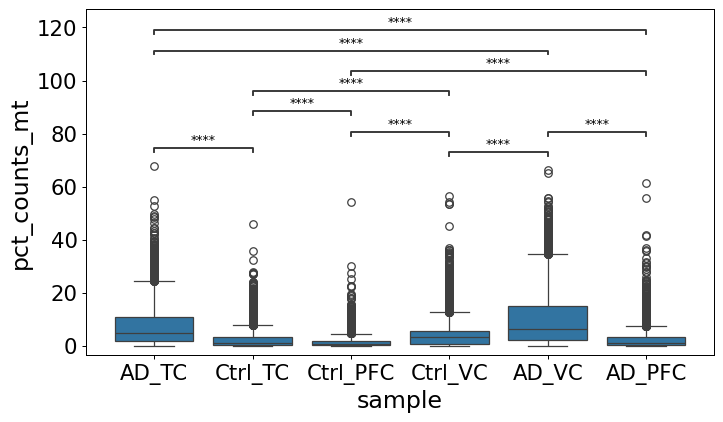

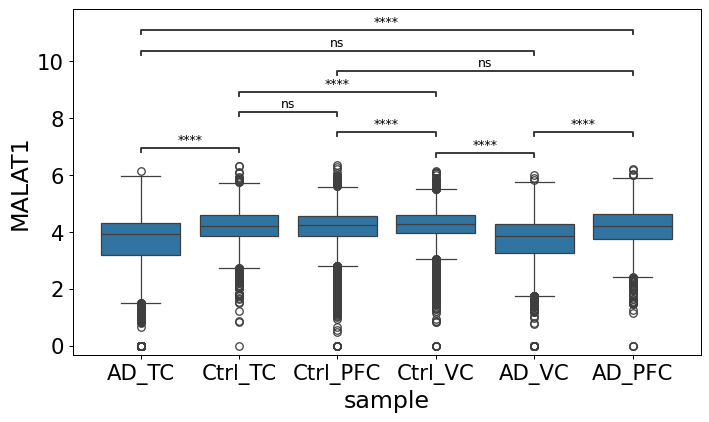

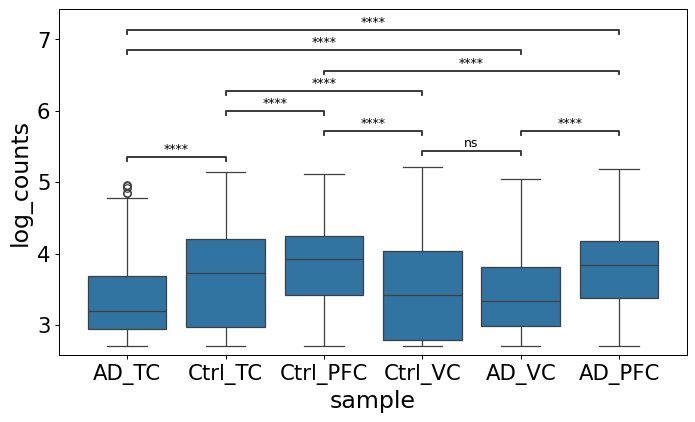

In [131]:
from statannotations.Annotator import Annotator
import seaborn as sns
import matplotlib.pyplot as plt

x = "sample"
y_list = ["pct_counts_mt", "MALAT1", "log_counts"]
# Define order for consistent display
#order = sorted(df[x].unique())

# Define comparisons between groups
pairs = [
    ("AD_PFC", "Ctrl_PFC"),
    ("AD_TC", "Ctrl_TC"),
    ("AD_VC", "Ctrl_VC"),
    ("Ctrl_TC", "Ctrl_VC"),
     ("Ctrl_PFC", "Ctrl_VC"),
     ("Ctrl_TC", "Ctrl_PFC"),
    ("AD_TC", "AD_VC"),
     ("AD_PFC", "AD_VC"),
     ("AD_TC", "AD_PFC")
]

for y in y_list:
    plt.figure(figsize=(9, 5))
    ax = sns.boxplot(data=df, x=x, y=y)
    
    # Add statistical annotation
    annot = Annotator(
        ax,
        pairs=pairs,
        data=df,
        x=x,
        y=y
    )
    annot.configure(
        test="Mann-Whitney",
        loc="inside",  # Use "outside" if space is tight
        text_format="star",
        show_test_name=False,
        verbose=1,
        comparisons_correction="bonferroni",  # Or None if no multiple testing correction
        fontsize=10
    )
    annot.apply_test()
    annot.annotate()
    
    # Final layout and save
    fig.tight_layout()
    plt.savefig(f"{FIG_DIR}/MWW_test_{y}.png")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. Ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.010e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. Ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.097e+08


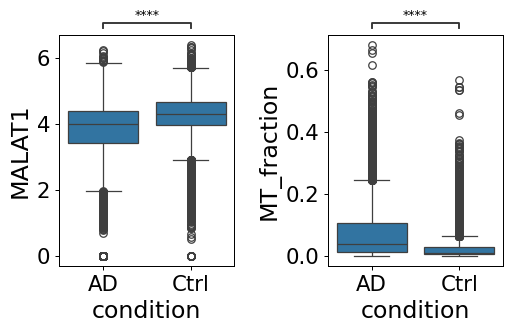

In [40]:
x = "condition"
features = ["MALAT1", "MT_fraction"]
# Define order for consistent display
order = sorted(df[x].unique())

# Define comparisons between groups
pairs = [
    ("AD", "Ctrl")
]

statistical_test_boxplot(df, x, features, pairs)

# Apply Filtering

First we want to check how many equal cells are removed from the thresholding. 

In [164]:
import pandas as pd

adata_filtered.obs["n_genes_outlier"] = False
adata_filtered.obs["n_counts_outlier"] = False
adata_filtered.obs["mt_outlier"] = False
adata_filtered.obs["nuclear_outlier"] = False

summary_df = []

for group in adata_filtered.obs['condition_area'].unique():
    min_genes, max_genes = n_genes_threshold[group]
    min_counts, max_counts = n_counts_threshold[group]
    mt_max = mt_threshold[group]
    malat1_max = malat1_threshold[group]
    
    # Create group mask
    group_mask = adata_filtered.obs['condition_area'] == group
    
    # Method 1: Calculate failures only for the group
    group_obs = adata_filtered.obs[group_mask]
    n_genes_fail = (group_obs['n_genes'] < min_genes) | (group_obs['n_genes'] > max_genes)
    n_counts_fail = (group_obs['n_counts'] < min_counts) | (group_obs['n_counts'] > max_counts)
    mt_fail = group_obs['pct_counts_mt'] > mt_max
    malat1_fail = group_obs['pct_counts_nuclear'] < malat1_max
    
    # Assign back to the full dataset using .loc
    adata_filtered.obs.loc[group_mask, "n_genes_outlier"] = n_genes_fail
    adata_filtered.obs.loc[group_mask, "n_counts_outlier"] = n_counts_fail
    adata_filtered.obs.loc[group_mask, "mt_outlier"] = mt_fail
    adata_filtered.obs.loc[group_mask, "nuclear_outlier"] = malat1_fail
    
    # Create summary dataframe
    df = pd.DataFrame({
        'group': group,
        'n_genes_fail': n_genes_fail.values,
        'n_counts_fail': n_counts_fail.values,
        'mt_fail': mt_fail.values,
        'nuclear_fail': malat1_fail.values
    }, index=group_obs.index)
    
    summary_df.append(df)

summary_df = pd.concat(summary_df)

In [166]:
groups = sorted(summary_df['group'].unique(), key=lambda g: (not g.startswith("Ctrl"), g))
n_groups = len(groups)

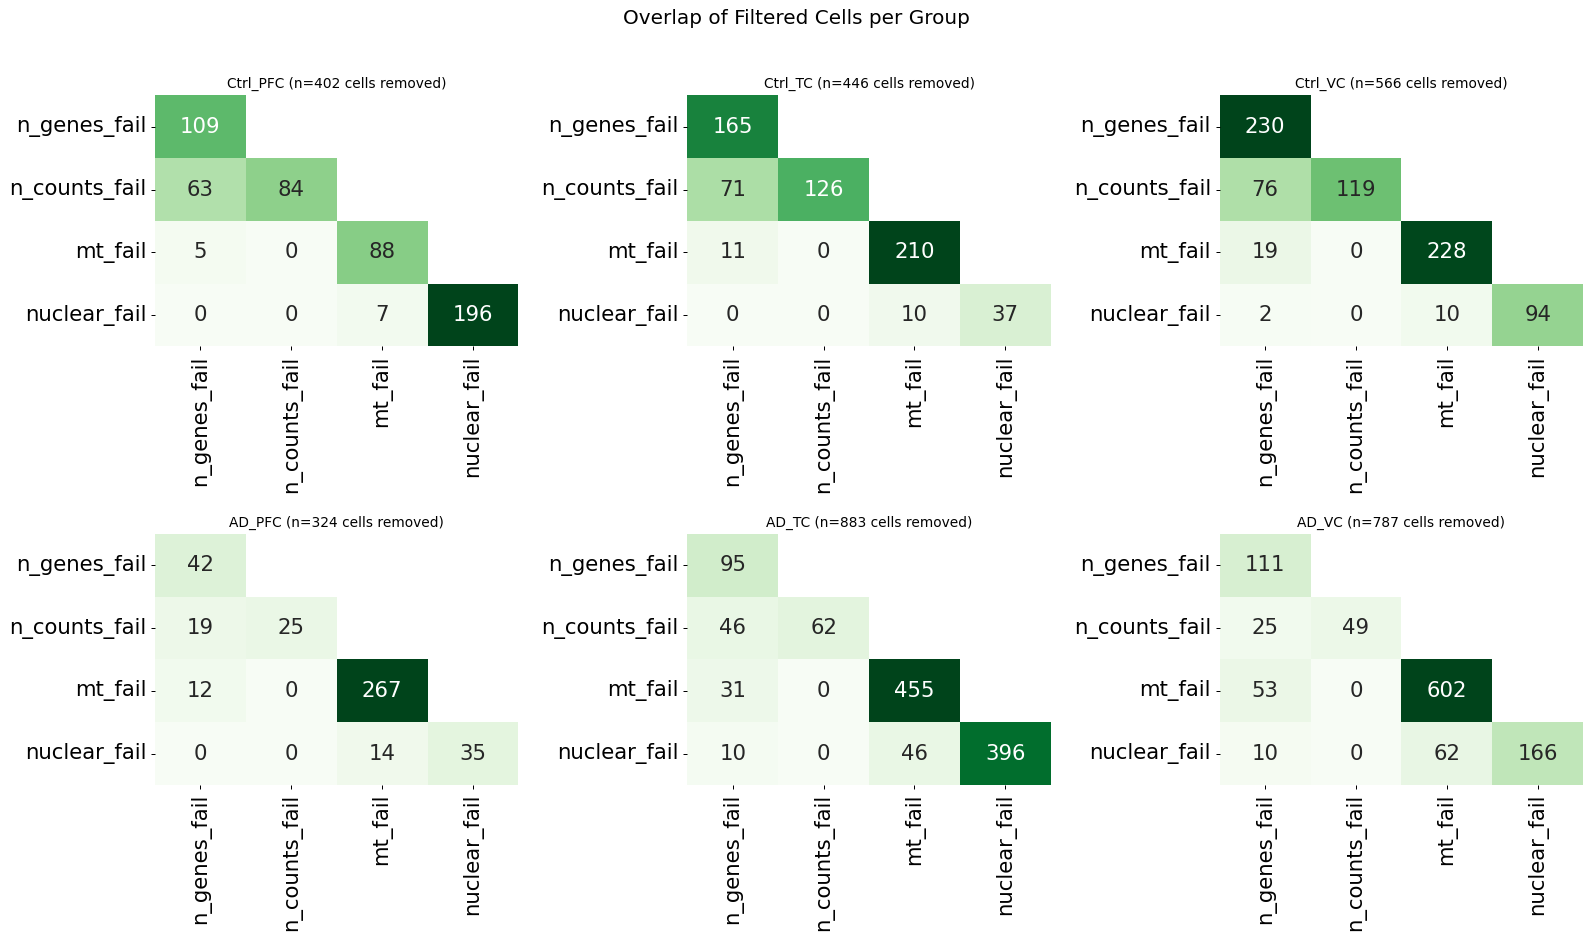

In [167]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, group in enumerate(groups):
    group_df_full = summary_df[summary_df['group'] == group]
    group_df = group_df_full.drop(columns='group').astype(int)

    # Count total number of filtered cells (cells failing at least one filter)
    total_filtered = (group_df.any(axis=1)).sum()

    # Compute overlap matrix
    overlap = group_df.T.dot(group_df)

    # Mask only the upper triangle *after* the diagonal
    mask = np.triu(np.ones_like(overlap, dtype=bool), k=1)

    # Plot
    sns.heatmap(overlap, annot=True, cmap='Greens', cbar=False, ax=axes[idx], fmt='d', mask=mask)
    axes[idx].set_title(f'{group} (n={total_filtered} cells removed)', fontsize=11)

# Hide unused subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Overlap of Filtered Cells per Group", fontsize=16, y=1.05)
plt.savefig(f"{FIG_DIR}/raw_count_overlap_filtered_groups.png")
plt.show()


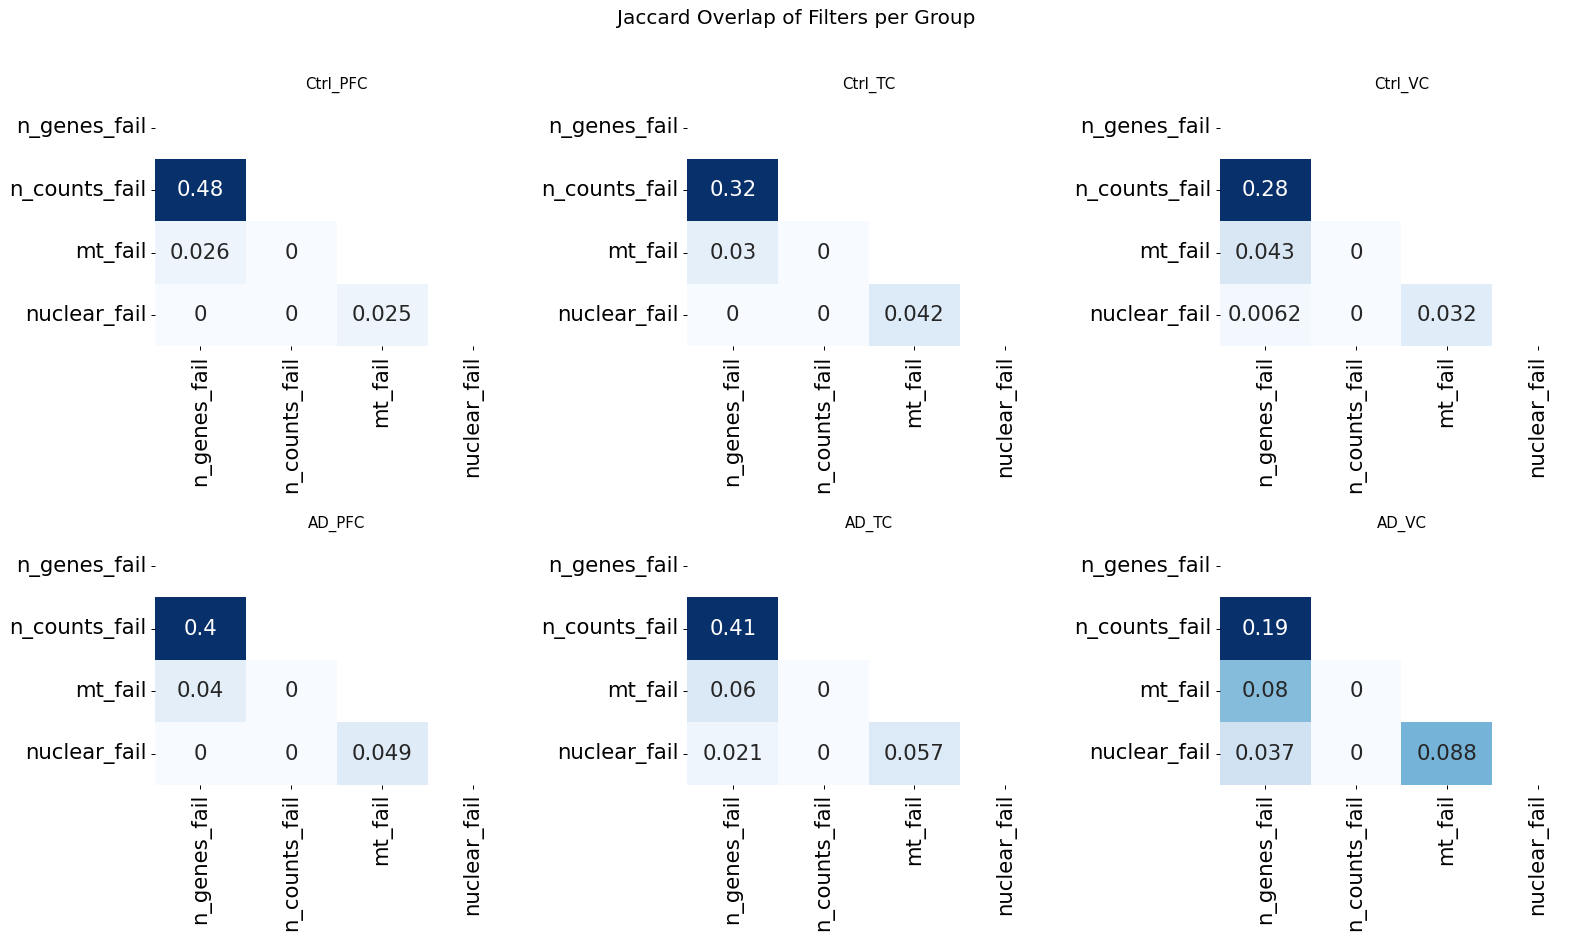

In [168]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()

for idx, group in enumerate(groups):
    group_df = summary_df[summary_df['group'] == group].drop(columns='group').astype(int)

    overlap = group_df.T.dot(group_df)
    total = group_df.sum().values.reshape(1, -1)
    jaccard = overlap / (total + total.T - overlap)

    # Mask upper triangle
    mask = np.triu(np.ones_like(jaccard, dtype=bool))

    sns.heatmap(jaccard, annot=True, mask=mask, cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{group}', fontsize=12)

# Turn off any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Jaccard Overlap of Filters per Group", fontsize=16, y=1.05)
plt.savefig(f"{FIG_DIR}/jaccard_overlap_filtered_groups.png")
plt.show()


In [169]:
pass_mask = ~(adata_filtered.obs[['n_genes_outlier', 'n_counts_outlier', 'mt_outlier', 'nuclear_outlier']].any(axis=1))
adata_qc = adata_filtered[pass_mask].copy()

In [183]:
print(f'Removed {len(adata_filtered.obs_names) - pass_mask.sum()} cells.')

Removed 3408 cells.


In [171]:
adata_qc

AnnData object with n_obs × n_vars = 36372 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden', 'braak_stage', 'area_abbrev', 'condition_area', 'outlier', 'mt_outlier', 'n_genes_outlier', 'n_counts_outlier', 'nuclear_outlier'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_

In [203]:
adata_qc.write(Path(DATA_DIR / f"{VERSION}_adata_filtered_counts_matrix_final.h5ad"))

## Quality controlled data

In [199]:
adata_qc = sc.read_h5ad(Path(DATA_DIR / f"{VERSION}_adata_filtered_counts_matrix_final.h5ad"))
adata_qc

AnnData object with n_obs × n_vars = 36372 × 78932
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'Brainbank source', 'sequencing id', 'sex', 'APOE genotype', 'brain area latin', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'log1p_counts', 'leiden', 'braak_stage', 'area_abbrev', 'condition_area', 'outlier', 'mt_outlier', 'n_genes_outlier', 'n_counts_outlier', 'nuclear_outlier'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_

### Adjust naming and clean up data

In [200]:
adata_qc.obs['brainbank'] = adata_qc.obs['Brainbank source']
adata_qc.obs['brain_area_latin'] = adata_qc.obs['brain area latin']

In [201]:
# clean up data
for obs in ['Brainbank source', 'brain area latin', 'pct_counts_in_top_20_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log1p_counts', 'leiden', 'outlier', 'mt_outlier', 'n_genes_outlier', 'n_counts_outlier', 'nuclear_outlier']:
    if obs in adata_qc.obs.columns:
        del adata_qc.obs[obs]

## Visualize data

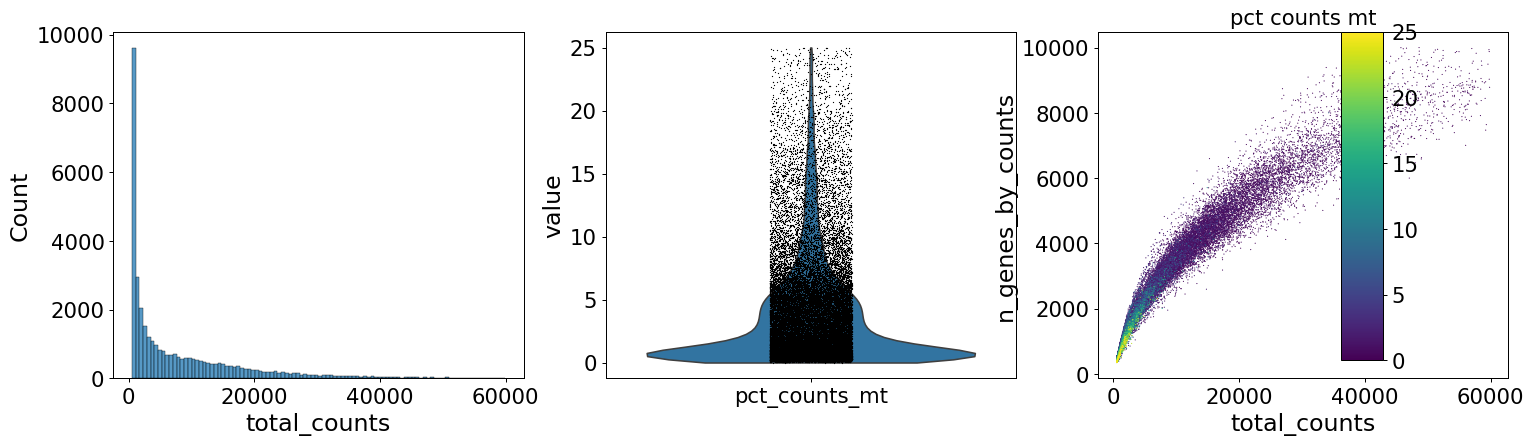

In [202]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plt.rcParams['figure.figsize']= (5, 3)
sns.histplot(adata_qc.obs["total_counts"], bins=100, kde=False, ax=axs[0])
sc.pl.violin(adata_qc, "pct_counts_mt", ax=axs[1], show=False)
sc.pl.scatter(adata_qc, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=axs[2], show=False, legend_loc='right margin' )

plt.savefig("sc_quality_control_final.png")  # Save full subplot
plt.show()